In [1]:
%matplotlib inline
import io, os, sys, types

# Imports own outside scripts
import Databaseloader as dl
import loadinvizerfit as lif
import jsonwriter
import readandplotfits as rpf
import writereg as wr
import dbtools
import cutout as ct
#########################################
import json
import glob
import matplotlib
import loadjson as ljs
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import tkp.db
from astropy.coordinates import SkyCoord
from tkp.db.model import Varmetric
from tkp.db.model import Runningcatalog
from tkp.db.model import Newsource
from tkp.db.model import Extractedsource
from tkp.db.model import Image
import operator
from operator import itemgetter, attrgetter

import logging
import pandas as pd
from pandas import DataFrame
import sqlalchemy
from sqlalchemy import *
from sqlalchemy.orm import relationship
#import Tools
#import generic_tools
#import plotting_tools
from scipy.stats import norm
import pylab
pylab.rcParams['legend.loc'] = 'best'
from matplotlib.ticker import NullFormatter
from matplotlib.font_manager import FontProperties
#from astroML import density_estimation

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.spatial import distance
import scipy.stats as ss
import scipy.optimize as op
import scipy.integrate as si
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install bokeh
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import DatetimeTickFormatter
from bokeh.models import ColumnDataSource, Whisker
from bokeh.io import export_png
output_notebook()
matplotlib.rcParams.update({'errorbar.capsize': 2})
logging.basicConfig(level=logging.INFO)

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Loading BokehJS ...

In [2]:
# Here you log in
engine = 
host = 
port = 
user = 
password = 
database=


websiteURL = 'http://banana.transientskp.org/r4/vlo_'+database+'/runningcatalog/'
latexURL = '\url{http://banana.transientskp.org/r4/vlo_'+database+'/runningcatalog/'
latexHREF = '\href{http://banana.transientskp.org/r4/vlo_'+database+'/runningcatalog/'
query_loglevel = logging.WARNING  # Set to INFO to see queries, otherwise WARNING


In [3]:
# this is sqlalchemy script to login to the Banana database
logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)
db = tkp.db.Database(engine=engine, host=host, port=port,
                     user=user, password=password, database=database)
db.connect()
session = db.Session()

# Here i get the peak flux and the error on the peak flux from all the sources in the database
fpeak = session.query(Extractedsource.f_peak).all()
fpeake = session.query(Extractedsource.f_peak_err).all()
typesextract = session.query(Extractedsource.fit_type).all()
# arParams = session.query(Varmetric,Runningcatalog).select_from(join(Varmetric,Runningcatalog)).filter(Runningcatalog.dataset_id == dataset_id).all()
califreq = np.load("freqlist.npy")
califlux = np.load("fluxlist.npy")

INFO:tkp.db.database:Database config: postgresql://kmeulen@vlo.science.uva.nl:5432/KmeulenSourceSub
/home/kmeulen/virtualenv/local/lib/python2.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:connected to: postgresql://kmeulen@vlo.science.uva.nl:5432/KmeulenSourceSub


Left off here <a name='bookmark' />

Go to <a href=#bookmark2>my bookmark</a>

Query to find the variability parameters of the sources in a specific dataset 

In [4]:
# Here I specifiy which dataset of the database to use
dataset_id = 2
timescale = "10min"
technique = database
savefigs = True
# runcat_id = 16077

# VarParams = session.query(Varmetric,Runningcatalog).select_from(join(Varmetric,Runningcatalog)).filter(Runningcatalog.dataset_id == dataset_id).all()
# imagecontrol = session.query(Runningcatalog,Image).filter(Runningcatalog.dataset_id == dataset_id).all()
session = dbtools.access(engine,host,port,user,password,database)
tables = ['image','varmetric','newsource']
PandasParams = dbtools.GetPandaExtracted(session,dataset_id,tables)

INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:connected to: postgresql://kmeulen@vlo.science.uva.nl:5432/KmeulenSourceSub


connected!


In [5]:
# print len(VarParams)
# print len(imagecontrol)
# for i in imagecontrol:
#     print i
print PandasParams.keys()
newPandas = PandasParams.drop_duplicates(subset='xtrsrc')


Index([               u'xtrsrc',               u'dataset',
                      u'runcat',            u'datapoints',
                        u'zone',                 u'wm_ra',
                     u'wm_decl',     u'wm_uncertainty_ew',
           u'wm_uncertainty_ns',            u'avg_ra_err',
                u'avg_decl_err',               u'avg_wra',
                   u'avg_wdecl',         u'avg_weight_ra',
             u'avg_weight_decl',                     u'x',
                           u'y',                     u'z',
                    u'inactive',               u'mon_src',
            u'forcedfits_count',                  u'band',
                      u'skyrgn',                 u'image',
                         u'tau',                u'stokes',
                    u'tau_time',              u'freq_eff',
                     u'freq_bw',           u'taustart_ts',
                     u'rb_smaj',               u'rb_smin',
                       u'rb_pa',                u'deltax

Make 2d array of all the sources except for the transients.

In [6]:
# plotdata = [[VarParams[i].Runningcatalog.id, VarParams[i].Runningcatalog.wm_ra,\
#              VarParams[i].Runningcatalog.wm_decl,VarParams[i].Runningcatalog.avg_ra_err,\
#              VarParams[i].Runningcatalog.avg_decl_err, VarParams[i].Runningcatalog.datapoints,\
#              session.query(Newsource).filter(Newsource.id==VarParams[i].Varmetric.newsource).one().newsource_type,\
#              VarParams[i].Varmetric.newsource,VarParams[i].Varmetric.lightcurve_max,
#              session.query(Newsource).filter(Newsource.id==VarParams[i].Varmetric.newsource).one().trigger_xtrsrc.id,VarParams[i].Varmetric.eta_int]\
#             for i in range(len(VarParams)) if VarParams[i].Varmetric.newsource != None]
# for i in plotdata:
#     if i[0] ==2877:
#         print i
# newPandas = PandasParams
# print newPandas['lightcurve_median']
# print PandasParams
# print len(newPandas)
# # for i in newPandas['url']:
# #     print i
# print PandasParams['fit_type']
# print PandasParams['runcat']
# print PandasParams['fit_type']
# for i in range(len(PandasParams['runcat'])):
# #     print PandasParams['runcat'][i]
#     if PandasParams['runcat'][i] == 5774:
#         print 'hoi'
#         print PandasParams['fit_type'][i]
# #         if PandasParams['fit_type'][i]==0:
# #             print PandasParams['url'][i]


In [7]:
plotdata = [[i.runcat, i.wm_ra,\
             i.wm_decl,i.avg_ra_err,\
             i.avg_decl_err, i.datapoints,\
             i.newsource_type,\
             i.newsource,i.lightcurve_max,
             i.xtrsrc,i.eta_int,i.url]\
            for index,i in newPandas.iterrows() if i.newsource != None]

In [8]:
print len(plotdata)
for i in plotdata:
    if i[0] ==5774:
#         print i[9]-1
        print i[8]
        
#         print fpeak[i[9]-1][0]


1483


In [9]:
# The de Ruiter distance as shown in the Trap Paper section 4.4 https://arxiv.org/abs/1503.01526 

def CalcDeRuiter(transient,ra2,ra2e,dec2,dec2e):

    ra1 = transient['ra']
    dec1 = transient['dec']
    ra1e = transient['rae']
    dec1e = transient['dece']


    r=(np.sqrt((((-1*ra2 +ra1)**2)*(np.cos((dec1+dec2)/2))**2)/\
                       (ra1e**2+ra2e**2)+((-1*dec2+dec1)**2/(dec1e**2+dec2e**2))))
    return r 

In [10]:
# Comparing the fluxes heavily inspired on the de Ruiter distance as used by Bart's thesis: https://api-alumni.nl/media/uploads/theses/phd/lha-scheers-phd.pdf page 55

def CompareFluxes(transient,pflux2,pflux2e,scale=1):
    pflux1 = transient['pflux']*scale
    pflux1e = transient['pfluxe']*scale
    
    r = np.sqrt((((-1*pflux2 +pflux1)**2))/\
                       (pflux1e**2+pflux2e**2))
    return r

In [11]:
# calculates the frequency flux scale based on supplied califreq and califlux data

def CalcFreqScale(transient,datafreq,califreq,califlux):
    """Function for calculating the frequency scale"""
    transfreq = transient.freq
    for i in range(len(califreq)):
        if transfreq - 0.005 <= califreq[i] <= transfreq + 0.005:
            oldflux = califlux[i]
        if datafreq - 0.005 <= califreq[i] <= datafreq + 0.005:
            newflux = califlux[i]
    scale = newflux/oldflux
    return scale

def CalcRelFlux(transient,datafreq,dataflux):
    transfreq = transient.freq
    scale = np.power((transfreq/datafreq),-0.7)*dataflux 
    return scale

Function for pruning our candidate list

Function for comparing transient candidate against external databases

In [12]:

def CheckSimOutsideDatabase(data,sources,rcheck,ycheck,checklight,gamma,Cali,deruiter = True,euccutoff = 0.06):
    """ Function for checking against outside database the data entry is for the database rcheck is condition \
where we check deruiter against, ycheck is where we check de flux against and checklight,gamma,deruiter\
are booleans which switch on checking the flux(checklight), checking using error on the flux(gamma) and \
using deruiter distance

"""
    masterindex = []
    savedilist = []
    print 'before:'
    if Cali:
        scale =  CalcFreqScale(sources[0],data.freq,califreq,califlux)
    else:
        scale = CalcRelFlux(sources[0],data.freq,data.pflux)

    print len(sources)
    
    for i in sources:
        indexlist = []

        r = CalcDeRuiter(vars(i),np.array(data.ra),np.array(data.rae),np.array(data.dec),np.array(data.dece))
        if gamma:
            y = CompareFluxes(vars(i),np.array(data.pflux),np.array(data.pfluxe),scale)

            for j in range(len(r)):

                if r[j] <=rcheck:
                    indexlist.append([j,r[j]])

            if checklight and indexlist:
                pfluxlist = []
                pfluxelist = []

                indexvalue = np.argmin(np.array(indexlist)[:,1])
                pfluxlist.append(data.pflux[indexlist[indexvalue][0]])
                pfluxelist.append(data.pfluxe[indexlist[indexvalue][0]])

                y = CompareFluxes(vars(i),np.array(pfluxlist),np.array(pfluxelist))


                if y[0]>=ycheck:

                    FluxVar(vars(i),indexlist[indexvalue][0],data,scale)


        else:
            for j in range(len(r)):
                if checklight:
                    if r[j] <=rcheck and (i.pflux*scale <= 0.9*data.pflux[j] or i.pflux*scale>=1.1*data.pflux[j]):
                        indexlist.append(j)
                        if i.id not in savedilist:
                            FluxVar(vars(i),j,data,scale)
                            savedilist.append(i.id)
                    elif r[j] <=rcheck:
                        indexlist.append(j)





                else:
                    if r[j] <=rcheck:
                        indexlist.append(j)

        masterindex.append(indexlist)
    
#     check if thereis a zero listentry in masterindex.. if so append it to the varying pos sources class.
    i = 0
    while i < len(masterindex):
        if not masterindex[i]:
            PosVar(vars(sources[i]),data)
        i+=1

    print 'after:'  
    print str(len(PosVar.instances)) +" Interesting candidates"
    print str(len(FluxVar.instances)) + " Flux Varying candidates"
    


Class object for saving our candidate transients, class object for storing objects that have varying flux compared to external database and
Initialize our transients class and other banana sources lists.

(This piece of code has to be rerun everytime you adjust something)

In [13]:

class Transients(object):
    instances = []
    def __init__(self,ra,rae,dec,dece,ids,pflux,pfluxe,url):
        self.id = ids
        y = np.stack((ra,dec),axis = -1)
        self.url = url
        self.ra = ra
        self.rae = rae
        self.dec = dec
        self.dece = dece
        self.pflux = pflux
        self.pfluxe = pfluxe
        self.freq = 144
        self.keys = ['yoloswag']
        self.radec = np.reshape(y,(1,2))
        c = SkyCoord(self.ra, self.dec, frame='fk5', unit='deg')
        self.fk5 = c.to_string('hmsdms',sep=' ',precision= 0)
        self.c = c
        Transients.instances.append(self)

    def DelFalse(i):
        del Transients.instances[i]

class PosVar(object):
    """class object for storing objects that have a varying position compared to the database we are looking in"""
    instances = []
    def __init__(self,params,database):
        self.id = params['id']            
        self.ra = params['ra']
        self.url = params['url']
        self.database = database
        self.dataname = database.name
        self.dec = params['dec']
        self.radec = params['radec']
        self.pflux = params['pflux']
        c = SkyCoord(params['ra'], params['dec'], frame='fk5', unit='deg')
        self.fk5 = c.to_string('hmsdms',sep=' ',precision= 0)
        self.c = c
        try:
            self.iflux = params['iflux']
        except:
            pass
        PosVar.instances.append(self)
        

class TestInstance(object):
    """class object for storing objects that have a varying position compared to the database we are looking in"""
    instances = []
    def __init__(self,params):
        self.id = params['id']            
        self.ra = params['ra']
        self.url = params['url']
        self.database = params['database']
        self.dataname = params['dataname']
        self.dec = params['dec']
        self.radec = params['radec']
        self.pflux = params['pflux']
        c = SkyCoord(params['ra'], params['dec'], frame='fk5', unit='deg')
        self.fk5 = c.to_string('hmsdms',sep=' ',precision= 0)
        self.c = c
        try:
            self.iflux = params['iflux']
        except:
            pass
        TestInstance.instances.append(self)
        
class SavedFluxSources(object):
    """class object for storing objects that have a varying position compared to the database we are looking in"""
    instances = []
    def __init__(self,initialid,initialpflux,initialpfluxerr,params):
        self.id = params['id']            
        self.ra = params['ra']
        self.url = params['url']
        self.dec = params['dec']
        self.rae = params['rae']
        self.dece = params['dece']
        self.radec = params['radec']
        self.pflux = params['pflux']
        self.freq = params['freq']
        self.pfluxe = params['pfluxe']
        c = SkyCoord(params['ra'], params['dec'], frame='fk5', unit='deg')
        self.fk5 = c.to_string('hmsdms',sep=' ',precision= 0)
        self.c = c
        self.cmpid = initialid
        self.cmppflux = initialpflux
        self.cmppfluxerr = initialpfluxerr
        try:
            self.iflux = params['iflux']
        except:
            pass
        SavedFluxSources.instances.append(self)

class SavedPosSources(object):
    """class object for storing objects that have a varying position compared to the database we are looking in"""
    instances = []
    def __init__(self,params):
        self.id = params['id']            
        self.ra = params['ra']
        self.url = params['url']
        self.dec = params['dec']
        self.rae = params['rae']
        self.dece = params['dece']
        self.radec = params['radec']
        self.pflux = params['pflux']
        self.freq = params['freq']
        self.pfluxe = params['pfluxe']
        c = SkyCoord(params['ra'], params['dec'], frame='fk5', unit='deg')
        self.fk5 = c.to_string('hmsdms',sep=' ',precision= 0)
        self.c = c
        try:
            self.iflux = params['iflux']
        except:
            pass
        SavedPosSources.instances.append(self)  
    
class FluxVar(object):
    """class object for storing objects that have a varying flux compared to the database we are looking in"""
    instances = []
    def __init__(self,params,databaseentry,database,scale):
        self.id = params['id']
        self.ra = params['ra']
        self.url = params['url']
        self.database = database
        self.dataname = database.name
        self.scale = scale
        self.dec = params['dec']
        self.radec = params['radec']
        self.pflux = params['pflux']
        self.entry = databaseentry
        c = SkyCoord(params['ra'], params['dec'], frame='fk5', unit='deg')
        self.fk5 = c.to_string('hmsdms',sep=' ',precision= 0)
        self.c = c
        c = c.icrs
        self.icrs = c.to_string('hmsdms',sep=' ',precision= 0)
        try:
            self.iflux = params['iflux']
        except:
            pass
        FluxVar.instances.append(self)
    

        
racata = []
raecata = []
deccata = []
dececata = []
idcata = []
lightcata = []
lightecata = []
idstorelist = []
for i in range(len(plotdata)):
    if plotdata[i][0] in idstorelist:
        continue
    else:
        if plotdata[i][6] == 1:
            Transients(plotdata[i][1],plotdata[i][3],plotdata[i][2],plotdata[i][4],plotdata[i][0],fpeak[plotdata[i][9]-1][0],fpeake[plotdata[i][9]-1][0],[plotdata[i][11]])
            idstorelist.append(plotdata[i][0])
        else:
            racata.append(plotdata[i][1])
            raecata.append(plotdata[i][3])
            deccata.append(plotdata[i][2])
            dececata.append(plotdata[i][4])
            idcata.append(plotdata[i][0])
#           -1 necessary to account for pythonic lists
            lightcata.append(fpeak[plotdata[i][9]-1][0])
            lightecata.append(fpeake[plotdata[i][9]-1][0])
        
X = np.stack((racata,deccata),axis = -1)

racata = np.array(racata)
raecata = np.array(raecata)
dececata = np.array(dececata)
deccata = np.array(deccata)
idcata = np.array(idcata)
lightcata = np.array(lightcata)
lightecata = np.array(lightecata)
# for i in Transients.instances:
#     print i.id
print idstorelist
# Transients(183,0.01,45,0.01,99999999,1.32,0.001)

[4315, 4551, 3743, 4209, 3851, 3643, 3597, 4210, 3931, 4083, 4320, 4138, 4428, 3936, 4851, 4848, 4365, 4942, 3991, 3816, 4646, 4685, 5013, 5064, 4802, 4977, 4595, 4739, 4941]


In [14]:
# rasl = []
# raesl = []
# decsl = []
# decesl = []
# idsl = []
# pfluxsl = []
# pfluxesl = []
# for i in range(len(plotdata)):
#     rasl.append(plotdata[i][1])
#     raesl.append(plotdata[i][3])
#     decsl.append(plotdata[i][2])
#     decesl.append(plotdata[i][4])
#     idsl.append(plotdata[i][0])
#     pfluxsl.append(fpeak[plotdata[i][9]-1][0])
#     pfluxesl.append(fpeake[plotdata[i][9]-1][0])



# raseries = pd.Series(racata)
# raseries
# ras = pd.Series(rasl, name='ra')
# raes = pd.Series(raesl, name='raerr')
# decs = pd.Series(decsl, name='dec')
# deces = pd.Series(decesl, name='decerr')
# ids = pd.Series(idsl, name='id')
# pfluxs = pd.Series(pfluxsl, name='pflux')
# pfluxes = pd.Series(pfluxesl, name='pfluxerr')

# pandacata = pd.concat([ras, raes,decs,deces,ids,pfluxs,pfluxes], axis=1)


here we call the function for calculating the de ruiter distance between candidates and our found sources and if True is given we also check if the max of the lightcurve of the sources compared fall withing 5 sigma flux of each other (thus making it increasingly likely for   the source to be a sidelobe)

This extra flux comparison is used in order to not potentially write of a faint or bright transient close to a known source.

In [15]:
def SelectorForCandidateslist(rcheck,ycheck,checklight,deruiter=True):
    """Function for pruning the candidate list using both distance and lightcurve measurements"""
    ctr = 0
    print 'before:'
    print len(Transients.instances)
    oldlen = len(Transients.instances) + 1
    savedinitiallength = len(Transients.instances)
    
# #   Repeat until no improvement in the length of the candidate list
#     while len(Transients.instances) - oldlen < 0:
    ratlist = []
    detclist = []

    translist = []
#         rlist = []
    oldlen = len(Transients.instances)

#         These lists are necessary to compare the candidate Transientss against each other
    ralist = []
    raelist = []
    declist = []
    decelist = []

# """Check candidate Transientss against each other"""

    for h in Transients.instances:
        if not deruiter:
            translist.append(h.radec)
        else:
            ralist.append(h.ra)
            raelist.append(h.rae)
            declist.append(h.dec)
            decelist.append(h.dece)
            

    masterindex = []
    savedlist = []
    first = True
    for i in Transients.instances:
        nocount = False
        indexlist = []



        r = CalcDeRuiter(vars(i),np.array(ralist),\
        np.array(raelist),np.array(declist),np.array(decelist))
        y = CompareFluxes(vars(i),np.array(lightcata),np.array(lightecata))
        for j in range(len(r)):

            if r[j] <=rcheck and r[j]!=0.0:
                indexlist.append(j)
                nocount = True
                        
#         SAVE ENTRIES THAT HAVE A BIG DIFFERENCE ON FLUX
        if checklight:
            pfluxlist = []
            pfluxelist = []
            for z in indexlist:            
                pfluxlist.append(Transients.instances[z].pflux)
                pfluxelist.append(Transients.instances[z].pfluxe)

            y = CompareFluxes(vars(i),np.array(pfluxlist),np.array(pfluxelist))
            
            if first:
                print y
                first = False
                try:
                    print Transients.instances[indexlist[0]].id
                except:
                    pass
            for o in range(len(y)):
                if y[o]>=ycheck:
                    SavedFluxSources(i.id,i.pflux,i.pfluxe,vars(Transients.instances[indexlist[o]]))
                    break
                    
                 
#         DELETE DOUBLE ENTRIES reform lists
        if nocount:
            k = 0
            g = 0
            while k < len(indexlist):
                del Transients.instances[indexlist[k]-g]

                k+=1
                g+=1

            ralist = []
            raelist = []
            declist = []
            decelist = []

            for h in Transients.instances:
                ralist.append(h.ra)
                raelist.append(h.rae)
                declist.append(h.dec)
                decelist.append(h.dece)


    print 'after:'
#     add back the no duplicate detections
#     for i in SavedPosSources.instances:
#         TestInstance(vars(i))
    print len(Transients.instances)
    print len(SavedFluxSources.instances)
    return str(len(Transients.instances)), savedinitiallength


In [16]:
initialselector,initiallenghtcandi = SelectorForCandidateslist(rcheck = 3, ycheck = 3,checklight = True, deruiter = True)


before:
29
[9.33299108 1.88351854 6.01457614 3.25204204 5.51480969 5.64373438
 7.10987952 6.61496743 4.56636878]
4551
after:
9
3


print out in latex format:

In [17]:
try:
    print SavedFluxSources.instances[1].pflux
    print Transients.instances[1].pflux
except:
    pass
FluxVar.instances = []
PosVar.instances = []

0.109659058253
0.118579674231


# tgss 
is the object which has tggs survey data for the field of P23 loaded into it.
could probably just automate it here but lets leave it for now

In [18]:
# this part reads in the tgss.csv file you downloaded from the tgss sources catalogue
tgsslist = dl.ReadData("tgss")
tgss = tgsslist[1]
print tgss.keys
print tgss.freq
print tgss.name
print len(tgss.ra)
print np.mean(tgss.rae)

['name', 'radec', 'ra', 'rae', 'dec', 'dece', 'pflux', 'pfluxe', 'freq']
147.5
tgss
98604
0.0006028485434442595


In [53]:
# Functoin call to check against sim data... cali False means use basic flux scale conversion cali True means use mine
# which is made using a calibrator source (would not work for different fields maybe or at all.. so yeah)
CheckSimOutsideDatabase(tgss,Transients.instances,rcheck = 3,ycheck = 3,\
                     checklight = True, gamma = True,Cali = False,deruiter = True,euccutoff = .06)

before:
9
after:
16 Interesting candidates
20 Flux Varying candidates


In [20]:
print Transients.instances[0].fk5
print Transients.instances[0].c
for i in Transients.instances:
    print i.ra

12 39 26 +47 28 07
<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (189.85783141, 47.46853443)>
189.857831408
181.952541824
-170.201414138
181.149789038
187.423999076
188.277324579
-178.851224112
-170.142720484
-174.209602641


## VLSSr

In [21]:
# this is the part where the vlssr.xls file gets loaded into the script.
vlssr = dl.ReadData('vlssr')[0]

print vlssr.keys
print vlssr.freq
print vlssr.ra

vlssrimage.fits
vlssrdataset.xls
*** No CODEPAGE record, no encoding_override: will use 'ascii'
*** No CODEPAGE record, no encoding_override: will use 'ascii'
*** No CODEPAGE record, no encoding_override: will use 'ascii'
*** No CODEPAGE record, no encoding_override: will use 'ascii'
['name', 'radec', 'ra', 'rae', 'dec', 'dece', 'pflux', 'pfluxe', 'freq']
74
[185.2953 184.7767 185.0477 ... 214.8349 165.3226 213.6304]


In [52]:

CheckSimOutsideDatabase(vlssr,Transients.instances,rcheck = 3 ,ycheck = 3,checklight = True,\
                     gamma = True,Cali=False,deruiter = True,euccutoff = 0.06)

before:
9
after:
12 Interesting candidates
15 Flux Varying candidates


In [23]:

savedpos = []
savedflux = []
print len(PosVar.instances)
print len(FluxVar.instances)
for i in PosVar.instances:
    if i.id not in savedpos:
        savedpos.append(i.id)
for i in FluxVar.instances:
    if i.id not in savedflux:
        savedflux.append(i.id)
        
posvarcatasave = len(savedpos)
fluxvarcatasave =  len(savedflux)
for i in PosVar.instances:
    print i.id
    print i.ra
    print i.dec
    print i.pflux

8
10
4209
-170.201414138
48.5628670875
0.119833530473
4942
-178.851224112
48.9487760903
0.109397307991
5064
-170.142720484
47.4685903467
0.188973053304
4977
-174.209602641
44.5920504553
0.123109289327
4209
-170.201414138
48.5628670875
0.119833530473
4942
-178.851224112
48.9487760903
0.109397307991
5064
-170.142720484
47.4685903467
0.188973053304
4977
-174.209602641
44.5920504553
0.123109289327


## Print saved flux sources LATEX

In [24]:
print "\\begin{longtable}{c|c|c|c|c|c|c|c|c|c} \n\
\\toprule \n Id & Ra (deg) & Dec (deg) & Fk5 & Flux & Fluxerr & cmpId & cmpFlux & cmpFluxerr & Candidate? (y/n)  \\\\\\midrule \n\\endfirsthead \n\\toprule \
\n Id & Ra (deg) & Dec (deg) & Fk5 & Flux & Fluxerr & cmpId & cmpFlux & cmpFluxerr & Candidate? (y/n)  \\\\\\midrule \n\\endhead \n\\bottomrule \n\\endfoot \n\\bottomrule"

# define caption for table
print "\\caption{ SAVED FLUX SOURCES} \n\\endlastfoot"
for i in SavedFluxSources.instances:
    print latexHREF + str(i.id) +"}{%i}" %(i.id)+ " " + "&"+ " " + '%0.3f' %i.ra + " " + "&"+ " "+ "%0.3f" %(i.dec) +\
    " " + "&" + i.fk5+"&" + " " + '%0.3f' %(i.pflux) +"&" + " " + '%0.3f' %(i.pfluxe) +"&" + " " +\
    latexHREF + str(i.cmpid) +"}{%i}" %(i.cmpid)\
    +"&" + " " +'%0.3f' %(i.cmppflux) +"&" + " "\
    + '%0.3f' %(i.cmppfluxerr) +"&" + " " +"\\" + "\\"
print "\\end{longtable}"

\begin{longtable}{c|c|c|c|c|c|c|c|c|c} 
\toprule 
 Id & Ra (deg) & Dec (deg) & Fk5 & Flux & Fluxerr & cmpId & cmpFlux & cmpFluxerr & Candidate? (y/n)  \\\midrule 
\endfirsthead 
\toprule 
 Id & Ra (deg) & Dec (deg) & Fk5 & Flux & Fluxerr & cmpId & cmpFlux & cmpFluxerr & Candidate? (y/n)  \\\midrule 
\endhead 
\bottomrule 
\endfoot 
\bottomrule
\caption{ SAVED FLUX SOURCES} 
\endlastfoot
\href{http://banana.transientskp.org/r4/vlo_KmeulenSourceSub/runningcatalog/4551}{4551} & 189.859 & 47.469 &12 39 26 +47 28 07& 0.240& 0.006& \href{http://banana.transientskp.org/r4/vlo_KmeulenSourceSub/runningcatalog/4315}{4315}& 0.162& 0.006& \\
\href{http://banana.transientskp.org/r4/vlo_KmeulenSourceSub/runningcatalog/3991}{3991} & 187.424 & 50.472 &12 29 42 +50 28 18& 0.110& 0.006& \href{http://banana.transientskp.org/r4/vlo_KmeulenSourceSub/runningcatalog/4138}{4138}& 0.157& 0.007& \\
\href{http://banana.transientskp.org/r4/vlo_KmeulenSourceSub/runningcatalog/5013}{5013} & -178.850 & 48.946 &12 04

# Print the same position Fluxvariating sources

In [25]:
for i in FluxVar.instances:
    
    print "Data compared to " + i.database.name
    print i.id
    print websiteURL+str(i.id)
    print 'bananaflux: ' + str(i.pflux*i.scale)

    print i.database.name+'flux: ' + str(i.database.pflux[i.entry])
    print i.database.ra[i.entry]
    print i.database.dec[i.entry]
    print "------------------------"
        

Data compared to tgss
4315
http://banana.transientskp.org/r4/vlo_KmeulenSourceSub/runningcatalog/4315
bananaflux: 0.15910132089613316
tgssflux: 1.0715
189.8559
47.472229999999996
------------------------
Data compared to tgss
3743
http://banana.transientskp.org/r4/vlo_KmeulenSourceSub/runningcatalog/3743
bananaflux: 0.11660985467948624
tgssflux: 1.4125
181.94637
45.23348
------------------------
Data compared to tgss
4320
http://banana.transientskp.org/r4/vlo_KmeulenSourceSub/runningcatalog/4320
bananaflux: 0.11079663939769269
tgssflux: 1.9209
181.1499
48.9485
------------------------
Data compared to tgss
4138
http://banana.transientskp.org/r4/vlo_KmeulenSourceSub/runningcatalog/4138
bananaflux: 0.15417745308846972
tgssflux: 0.4818
187.41866000000002
50.47232
------------------------
Data compared to tgss
4365
http://banana.transientskp.org/r4/vlo_KmeulenSourceSub/runningcatalog/4365
bananaflux: 0.11086040156066741
tgssflux: 0.9341
188.27766
45.48344
------------------------
Data comp

# Print the same position Fluxvariating sources in Latex ready format

In [26]:
# print "\\begin{landscape}\n"
# print "\\section{Fluxvariating Sources}\n"
# # SEPERATE DATABASES
# databaselist = ['tgss','vlssr']

# samesieslist = []
# for i in range(len(FluxVar.instances)):
#     samesie = False
#     tempdict = {'tgss':None,'vlssr':None,'id':None,'ra':None,'dec':None,'fk5':None}
    
# #   create combined name if entry both in vlssr and tgss
#     for j in range(len(samesieslist)):
#         if FluxVar.instances[i].id == samesieslist[j]['id']:
# #             samesieslist[j].append(FluxVar.instances[i])
#             samesieslist[j][FluxVar.instances[i].database.name] = FluxVar.instances[i]
          
#             samesie = True
#     if not samesie:
#         tempdict[FluxVar.instances[i].database.name] = FluxVar.instances[i]
#         tempdict['id'] = FluxVar.instances[i].id
#         tempdict['ra'] = FluxVar.instances[i].ra
#         tempdict['dec'] = FluxVar.instances[i].dec
#         tempdict['fk5'] = FluxVar.instances[i].fk5
#         samesieslist.append(tempdict)


# print "\\begin{longtable}{c|c|c|c|c|c|c|c|c|c|c|c|c} \n\
# \\toprule \nFlux147.5MHz (Jy) & Tgss (Jy) & Flux74MHz (Jy)& Vlssr (Jy) & fk5 & Ra (deg) & Dec (deg) &tggsRa&tgssDec&\
# vlssrRa&vlssrDec& Id/Link & (y/n)  \\\\\\midrule \n\\endfirsthead \n\\toprule \
# \nFlux147.5MHz (Jy) & Tgss (Jy) & Flux74MHz (Jy)& Vlssr (Jy)& fk5 & Ra (deg) & Dec (deg)  &tggsRa&tgssDec&\
# vlssrRa&vlssrDec& Id/Link & (y/n) \\\\\\midrule \n\\endhead \n\\bottomrule \n\\endfoot \n\\bottomrule"

# # define caption for table
# print "\\caption{ Comparison of variable fluxes with the same position for different databases 1hr} \n\\endlastfoot"
# lastname = None
# # samesieslist = sorted(samesieslist, key=lambda e: (e['ra'], e['dec']))
# for i in samesieslist:
#     a= ''
#     b=''
#     for j in(databaselist):
#         try: 
#             a+= str(np.around(i[j].pflux*i[j].scale,3)) + " " + "&"+ " "
#         except:
#             a += "-" +" "+ "&"+ " "
#         try:
#             a+= str(np.around(i[j].database.pflux[i[j].entry],3)) + " " + "&"+ " "   
#         except:
#             a += "-" +" "+ "&"+ " "
            
#         try: 
#             b+= '%0.3f' %(i[j].database.ra[i[j].entry])+" "+"&"+" "
#             b+= '%0.3f' %(i[j].database.dec[i[j].entry])+" "+"&"+" "
#         except:
#             b+= "-" + " " + "&"+" " "-" + " " + "&"+" "
        
#     a +=i['fk5'] + " " + '&' + "  "+ '%0.3f' %i['ra'] + " " + "&"+ " "+ "%0.3f" %i['dec'] \
#     + " " + '&' + "  "+ b+ latexHREF +str(i["id"])+"}" + "{%i}" %i['id'] +" "+"&"+" "+  "\\" + "\\"
#     print a

# print "\\end{longtable}\n"
# print "\\end{landscape}\n"

# Print the Position variating sources in Latex ready format

In [27]:
# # SEPERATE DATABASES

# print "\\begin{longtable}{c|c|c|c|c|c} \n\
# \\toprule \nDatabase & Ra (deg) & Dec (deg) & Fk5 & Id/Link & Candidate? (y/n)  \\\\\\midrule \n\\endfirsthead \n\\toprule \
# \nDatabase & Ra (deg) & Dec (deg) & Fk5 & Id/Link & Candidate? (y/n)  \\\\\\midrule \n\\endhead \n\\bottomrule \n\\endfoot \n\\bottomrule"

# # define caption for table
# print "\\caption{ Comparison position of candidates with different databases for the 10 min interval data} \n\\endlastfoot"
# lastname = None
# for i in PosVar.instances:
#     if i.database.name != lastname and lastname:
#         print "\\hline"
#     print i.database.name +" "+ "&"+ " " + '%0.3f' %i.ra + " " + "&"+ " "+ "%0.3f" %i.dec +\
#     " " + "&" + " " + i.fk5 +" " + '&' + "  "+ latexHREF +str(i.id)+"}" + "{%i}" %i.id +" " + '&' + "  "+"\\" + "\\"
    
#     lastname = i.database.name

# print "\\end{longtable}"

In [28]:
# # COMBINED DATABASES (SLOWER)
# print "\\begin{1andscape}\n"
# print "\\section{Position variating Sources}\n"
# samesieslist = []
# for i in range(len(PosVar.instances)):
#     samesie = False
    
# #   create combined name if entry both in vlssr and tgss
#     for j in range(len(samesieslist)):
#         if PosVar.instances[i].id == samesieslist[j][0]:
#             samesieslist[j][1] = samesieslist[j][1] + " \& " + PosVar.instances[i].database.name
#             samesie = True
#     if not samesie:
#         samesieslist.append([PosVar.instances[i].id,PosVar.instances[i].database.name,PosVar.instances[i]])
    
# samesieslist = sorted(samesieslist, key=itemgetter(1))

# print "\\begin{longtable}{c|c|c|c|c|c} \n\
# \\toprule \nDatabase & Ra (deg) & Dec (deg)& Fk5 & Id/Link & Candidate? (y/n)  \\\\\\midrule \n\\endfirsthead \n\\toprule \
# \nDatabase & Ra (deg) & Dec (deg) & Fk5 &Id/Link & Candidate? (y/n)  \\\\\\midrule \n\\endhead \n\\bottomrule \n\\endfoot \n\\bottomrule"

# # define caption for table
# print "\\caption{ Comparison position of candidates with different databases for the 1hr interval data} \n\\endlastfoot"
# lastname = None
# for i in samesieslist:
#     if i[1] != lastname and lastname:
#         print "\\hline"
#     print i[1] +" "+ "&"+ " "+ '%0.3f' %i[2].ra + " " + "&"+ " "+ "%0.3f" %(i[2].dec) +\
#     " " + "&" + " " +i[2].fk5 +" " + '&' + "  "+ latexHREF +str(i[0])+"}" + "{%i}" %i[0] +" " + '&' + "  "+"\\" + "\\"
    
#     lastname = i[1]

# print "\\end{longtable}\n"
# print "\\end{landscape}\n"

In [29]:
jsonwriter.WriteFluxJson(FluxVar.instances)



In [30]:
try:
    os.remove('neat.json')
except:
    print 'allready removed'

!{sys.executable} -m scrapy runspider scrapper.py -o neat.json
    
 
dfFlux = ljs.Loadin()


/home/kmeulen/virtualenv/local/lib/python2.7/site-packages/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a 2.7.x release that supports hmac.compare_digest as soon as possible.
  utils.DeprecatedIn23,
2018-12-24 12:53:02 [scrapy.utils.log] INFO: Scrapy 1.5.1 started (bot: scrapybot)
2018-12-24 12:53:02 [scrapy.utils.log] INFO: Versions: lxml 4.2.5.0, libxml2 2.9.8, cssselect 1.0.3, parsel 1.5.0, w3lib 1.19.0, Twisted 18.7.0, Python 2.7.6 (default, Nov 23 2017, 15:49:48) - [GCC 4.8.4], pyOpenSSL 18.0.0 (OpenSSL 1.1.0i  14 Aug 2018), cryptography 2.3.1, Platform Linux-3.13.0-141-generic-x86_64-with-Ubuntu-14.04-trusty
2018-12-24 12:53:02 [scrapy.crawler] INFO: Overridden settings: {'SPIDER_LOADER_WARN_ONLY': True, 'FEED_FORMAT': 'json', 'FEED_URI': 'neat.json'}
2018-12-24 12:53:02 [scrapy.middleware] INFO: Enabled extensions:
['scrapy

In [31]:
print dfFlux

          e    id    nu      s_nu
0        []  4138    []        []
1   1.8e+02  4320   325  9.22e+02
2   3.4e+02  4320   151  1.72e+03
3   4.8e+01  4320  1400  2.39e+02
4   1.5e+02  4320   365  7.73e+02
5   5.1e+01  4320  1400  2.56e+02
6   2.2e+01  4320  4885  1.11e+02
7   8.2e+01  4315   365  4.10e+02
8        []  3743    []        []
9   3.4e+01  4365  1400  1.70e+02
10  1.6e+02  4365   151  8.18e+02
11  1.1e+02  4365   325  5.42e+02
12  3.1e+01  4365  1400  1.54e+02
13  9.8e+01  4365   365  4.91e+02


In [32]:

# models to try
def starmodel(value,a,b,c):
    return a*value**-b+c

def starmodel2(value,*par):
    return 10**(-np.log(value)*par[0] + par[1])

def starmodel3(value,*par):
    return 10**(-np.log(value*par[0])-np.exp(value)*par[1] + par[2])

def ChiSq2(parm, xval, yval, dy): # the weighted least-squares
    ymod = starmodel2(xval,*parm)
    chisq = sum(pow((yval-ymod)/dy,2))
    return chisq


In [33]:


# specid = dfFlux[dfFlux.id == i]
# print specid
# freq = np.array(specid.nu)
# print freq.astype(float)
# ids = int(i)
# freq = np.array(specid.nu.astype(float))
# flux = np.array(specid.s_nu.astype(float))
# fluxerr = np.array(specid.e.astype(float))

In [34]:
def matplotlibfunction(frame,freq,flux,fluxerr,colour):
    
    
    #xstart, ystart, xend, yend [units are fraction of the image frame, from bottom left corner]
    
    plt.errorbar(freq,flux,yerr = fluxerr,color=colour,fmt = '.',ecolor='black') #Noisy data


# get our own data
def getSourceData2(frame,runcat_id,colour):
    runcat = session.query(tkp.db.model.Runningcatalog).filter(tkp.db.model.Runningcatalog.id==runcat_id).one()
    sources = runcat.extractedsources
    
    flux = []
    fluxerr = []
    freq = []
    
    for s in sources:
        if s.extract_type == 0:
            flux.append(s.f_int*10**3)
            fluxerr.append(s.f_int_err*10**3)
            freq.append(s.image.freq_eff/(1.*10**6))

    matplotlibfunction(frame,freq,flux,fluxerr,colour)
# #Residual plot
# difference = Fofx(x,*p) - ydata


In [35]:
# plot function
def bokehplotfunction(d,freq,flux,fluxerr,colour):
    lower = []
    upper = []
    base =[]
    for i in range(len(flux)):
        lower.append(flux[i]-fluxerr[i])
        upper.append(flux[i]+fluxerr[i])
        base.append(freq[i])

    d.scatter(freq,flux,color =colour)
    source_error = ColumnDataSource(data=dict(base=base, lower=lower, upper=upper))

    d.add_layout(
        Whisker(source=source_error, base="base", upper="upper", lower="lower")
    )
    return d

# make a fit
def fitexistingdata(freq,flux,fluxerr,ids,x):
    a=0.001
    b = 10
    c = 100

        
    p01=[b,c]
    fitfunction = starmodel2
        
    ml_cfpars, ml_cfcovar = op.curve_fit(fitfunction, freq, flux, p01, sigma=fluxerr)
    err = np.sqrt(np.diag(ml_cfcovar))
    confidence = np.diag(ml_cfcovar)
    fit = fitfunction(x, *ml_cfpars)
    dof = len(freq)-len(p01)
    chisquare = ChiSq2(ml_cfpars,freq,flux,fluxerr)
    return fit,chisquare,dof,ml_cfpars, ml_cfcovar

# get our own data
def getSourceData(d,runcat_id,colour):
    runcat = session.query(tkp.db.model.Runningcatalog).filter(tkp.db.model.Runningcatalog.id==runcat_id).one()
    sources = runcat.extractedsources
    
    flux = []
    fluxerr = []
    freq = []
    
    for s in sources:
        if s.extract_type == 0:
            flux.append(s.f_int*10**3)
            fluxerr.append(s.f_int_err*10**3)
            freq.append(s.image.freq_eff/(1.*10**6))

    bokehplotfunction(d,freq,flux,fluxerr,colour)
    return d,freq,flux,fluxerr




# RUN THE FIT

hoi
[147.5  74. ]
with a goodness of fit of: 0.000 and a dof of: 0.0


/home/kmeulen/virtualenv/local/lib/python2.7/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


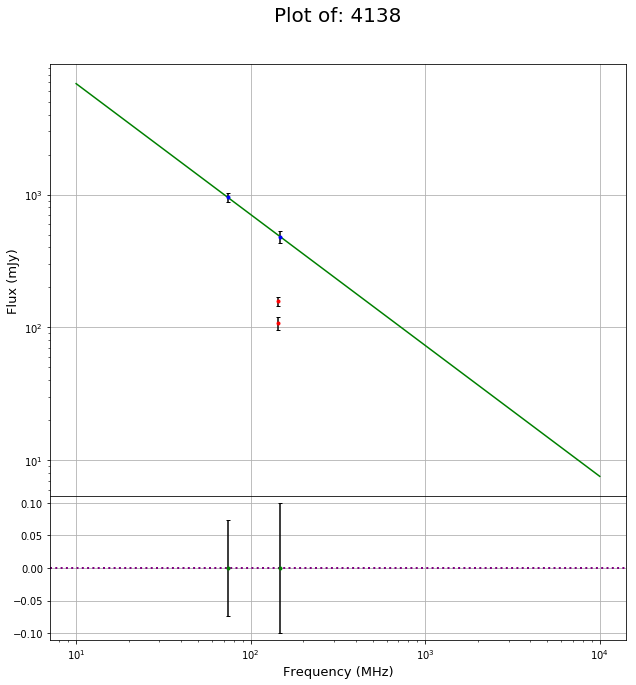

[ 325.   151.  1400.   365.  1400.  4885.   147.5   74. ]
with a goodness of fit of: 1.671 and a dof of: 6.0


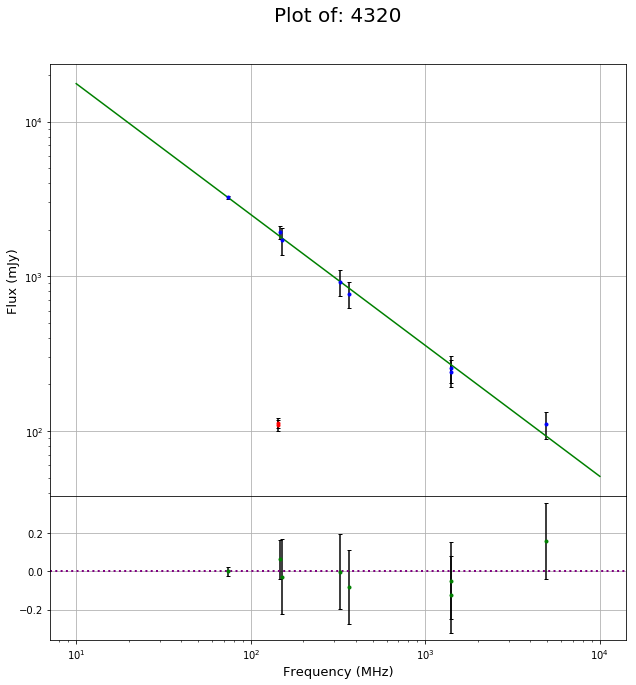

[365.  147.5  74. ]
with a goodness of fit of: 0.862 and a dof of: 1.0


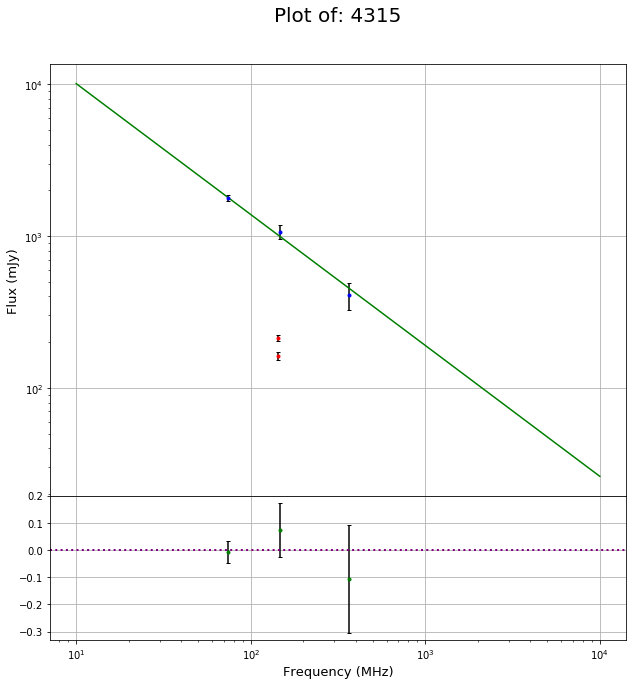

hoi
[147.5  74. ]
with a goodness of fit of: 0.000 and a dof of: 0.0


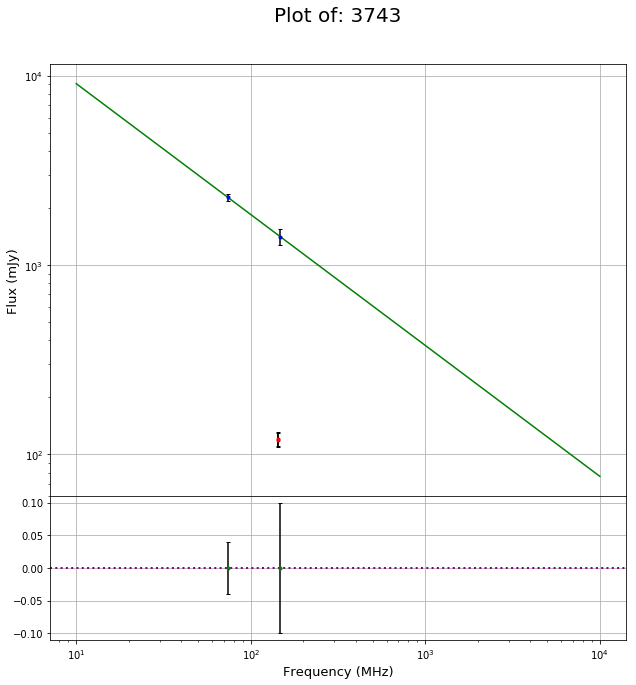

[1400.   151.   325.  1400.   365.   147.5   74. ]
with a goodness of fit of: 4.393 and a dof of: 5.0


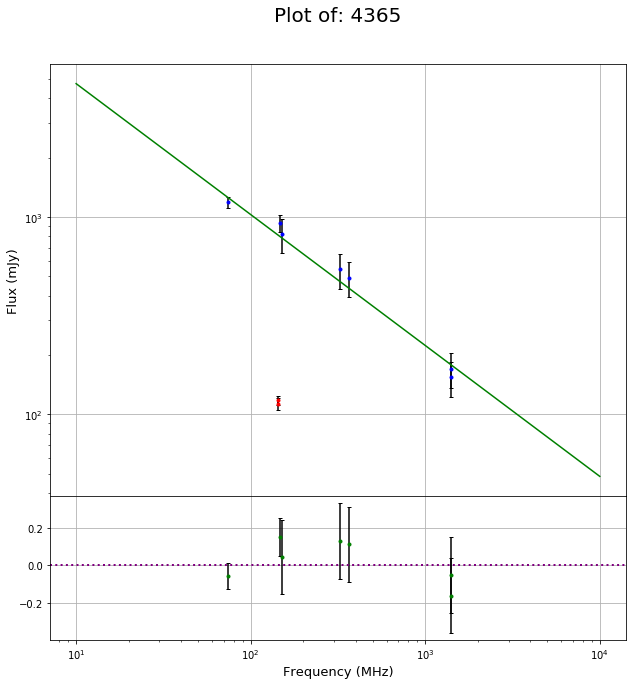

In [36]:
storedfitvalueslist = []
# initialize x
x = np.arange(1e1, 1e4, 1)

# loops through the data gathered sorting by id and plotting the fit

for i in dfFlux.id.unique():
    specid = dfFlux[dfFlux.id == i]
    ids = int(i)
    try:
        freq = np.array(specid.nu.astype(float))
        flux = np.array(specid.s_nu.astype(float))
        fluxerr = np.array(specid.e.astype(float))
    except:
        print 'hoi'
        freq = np.array([])
        flux = np.array([])
        fluxerr=np.array([])
    
#     Append catalogue data to the set:
    for j in FluxVar.instances:
        if j.id == ids:
            freq = np.append(freq,j.database.freq)
            flux = np.append(flux,j.database.pflux[j.entry]*10**3 )
            fluxerr = np.append(fluxerr,j.database.pfluxe[j.entry]*10**3 )

    print freq
    
    #Initialize figure
    fig1 = plt.figure(1,figsize=(10,10))
    fig1.suptitle("Plot of: " + str(ids),fontsize=20)
    
    #add first frame
    frame1=fig1.add_axes((.1,.3,.8,.6))
    matplotlibfunction(frame1,freq,flux,fluxerr,"blue")
    

    
    try:
        fit,chisquare,dof,ml_cfpars, ml_cfcovar = fitexistingdata(freq,flux,fluxerr,ids,x)

    except:
        print "for id: %i there is no good fit" %ids
        chisquare = 0
        dof = 0
        fit = None
        ml_cfpars = None
        print freq

    
    try:
        print "with a goodness of fit of: %0.3f and a dof of: %0.1f" %(chisquare,dof)
        
    except:
        pass
    
    getSourceData2(frame1,int(ids),colour = 'red')
    
#   initialize normal frame
    frame1.set_xscale('log')
    frame1.set_yscale('log')
    frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
    frame1.set_ylabel("Flux (mJy)",fontsize = 13)
    try:
        plt.plot(x,fit,color='green')
    except:
        pass
    plt.grid()
    
    #   initialize residual frame
    try:
        frame2=fig1.add_axes((.1,.1,.8,.2),sharex = frame1) 
        matplotlibfunction(frame2,freq,(flux-starmodel2(freq,*ml_cfpars))/flux,fluxerr/flux,'green')
        plt.axhline(0.0, color='purple', linestyle='dotted', lw=2)
        frame2.set_xscale('log')
        frame2.set_xlabel('Frequency (MHz)',fontsize=13)
        plt.grid()
    except:
        pass

    if savefigs:
        try:
            homedir = os.getcwd()
            newdir = homedir+"/" +timescale+"_"+ technique
            os.mkdir(newdir)
            os.chdir(newdir)
            plt.savefig(timescale + str(ids) +".png" )
            os.chdir(homedir)
        except:
            os.chdir(newdir)
            plt.savefig(timescale + str(ids) +".png" )
            os.chdir(homedir)
    try:
        storedfitvalueslist.append([ids,chisquare,dof])
    except:
        storedfitvalueslist.append([ids,0,0])
    plt.show() 
    


In [37]:
# print storedfitvalueslist

# Do not add tgss or vlssr data to the fit for this singular source where shit hits the fan

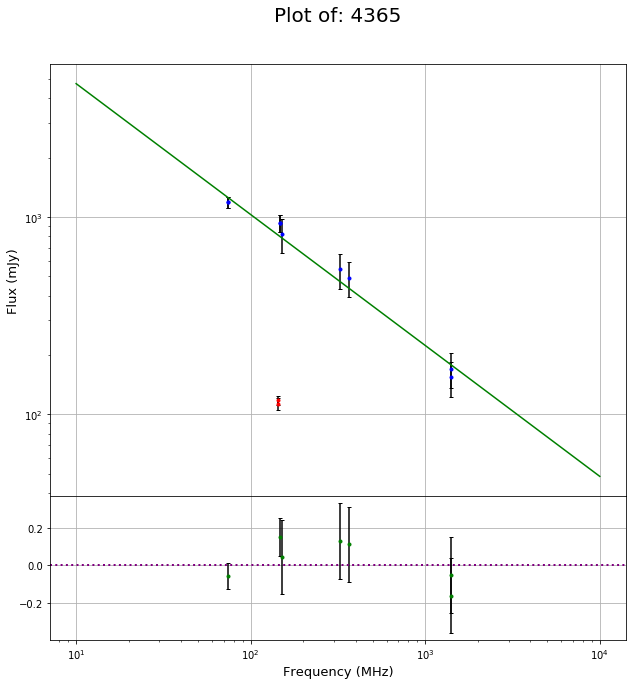

__________________________________________________________________________________________


In [38]:
weirdactingid = 7605
for i in dfFlux.id.unique():
    if i == str(weirdactingid):
        specid = dfFlux[dfFlux.id == i]
        ids = int(i)
        freq = np.array(specid.nu.astype(float))
        flux = np.array(specid.s_nu.astype(float))
        fluxerr = np.array(specid.e.astype(float))
        ids = int(i)
        
for i in range(len(storedfitvalueslist)):
    if storedfitvalueslist[i][0]== weirdactingid:
        print storedfitvalueslist[i]
        del(storedfitvalueslist[i])
        
# Initialize figure
fig1 = plt.figure(1,figsize=(10,10))
fig1.suptitle("Plot of: " + str(ids),fontsize=20)

#add frame1
frame1=fig1.add_axes((.1,.3,.8,.6))
matplotlibfunction(frame1,freq,flux,fluxerr,"blue")


# initialize x
x = np.arange(1e1, 1e4, 1)
try:
    fit,chisquare,dof,ml_cfpars, ml_cfcovar = fitexistingdata(freq,flux,fluxerr,ids,x)

except:
    print "for id: %i there is no good fit" %ids
    print freq
    
    
    

for j in FluxVar.instances:
    if j.id == ids:

        matplotlibfunction(frame1,j.database.freq,j.database.pflux[j.entry]*10**3,j.database.pfluxe[j.entry]*10**3,colour='blue')



getSourceData2(frame1,int(ids),colour = 'red')

# Initialize normal frame
frame1.set_xscale('log')
frame1.set_yscale('log')
frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
frame1.set_ylabel("Flux (mJy)",fontsize = 13)
plt.plot(x,fit,color='green')
plt.grid()

# initialize residuals frame
frame2=fig1.add_axes((.1,.1,.8,.2),sharex = frame1) 
matplotlibfunction(frame2,freq,(flux-starmodel2(freq,*ml_cfpars))/flux,fluxerr/flux,'green')
plt.axhline(0.0, color='purple', linestyle='dotted', lw=2)
frame2.set_xscale('log')
frame2.set_xlabel('Frequency (MHz)',fontsize=13)
plt.grid()

storedfitvalueslist.append([ids,chisquare,dof])
# if we wanna save we save
if savefigs:
    os.chdir(newdir)
    plt.savefig(timescale + str(ids) +".png" )
    os.chdir(homedir)
plt.show()
# make figure for and get the residuals

# p = figure(title="residuals", x_axis_label='freq (MHz)', y_axis_label='flux(mJy)',x_axis_type='log')


# p = bokehplotfunction(p,freq,(flux-starmodel2(freq,*ml_cfpars))/flux,fluxerr/flux,'green')
# p.line(x,0,color='purple',line_dash='dashed')

# show(p)
print "__________________________________________________________________________________________"

# Make Reg.file for quick comparison in original data

In [39]:
try:
    os.chdir(newdir)
except:
    homedir = os.getcwd()
    newdir = homedir+"/" +timescale+ "_"+technique
    os.mkdir(newdir)
    os.chdir(newdir)

wr.WriteReg(timescale,PosVar.instances,FluxVar.instances)
os.chdir(homedir)

# TEST MAKE IMAGES FOR TGSS

In [40]:
# jsonwriter.WriteFluxJson(PosVar.instances,pos=True)

In [41]:
# jsonFile = open("tgpos.json","r")
# datalistjson = json.load(jsonFile)
# n = len(datalistjson)
# jsonFile.close()
# try:
#     os.remove('poslink.json')
# except:
#     print 'allready removed'
# for i in range(n):
#     !{sys.executable} -m scrapy runspider databasescrapper.py -o poslink.json






## Download tgss fits images

In [42]:
# os.chdir(homedir)
# try:
#     os.rename(homedir+"/poslink.json", newdir+"/poslink.json")
# except:
#     pass
# try:
#     os.rename(homedir+"/downloader.py", newdir+"/downloader.py")
# except:
#     pass


# os.chdir(newdir)
# !{sys.executable} downloader.py

# try:
#     os.rename(newdir+"/downloader.py", homedir+"/downloader.py")
# except:
#     pass

# os.chdir(homedir)



## Convert fits to png

In [43]:

# os.chdir(newdir)
# imagez = glob.glob('*.fits')
# # for i in imagez:
# # #     print i
# #     rpf.Imager(i)
# for i in PosVar.instances:
#     if i.dataname == 'tgss':
#         a = str(i.id) +'tgss.fits'
#         print i.ra
#         print i.dec
#         print i.id
#         rpf.Imager(a,i.ra,i.dec)



# Make cutouts vlssr

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 180.0  45.0  
CRPIX : 2040.0  2040.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.004166667  0.004166667  
NAXIS : 0  0
[120. 120.] pix
WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'FREQ'  'STOKES'  
CRVAL : 180.0  45.0  73793896.48435  1.0  
CRPIX : 2040.0  2040.0  1.0  1.0  
NAXIS : 4079  4079  1  1


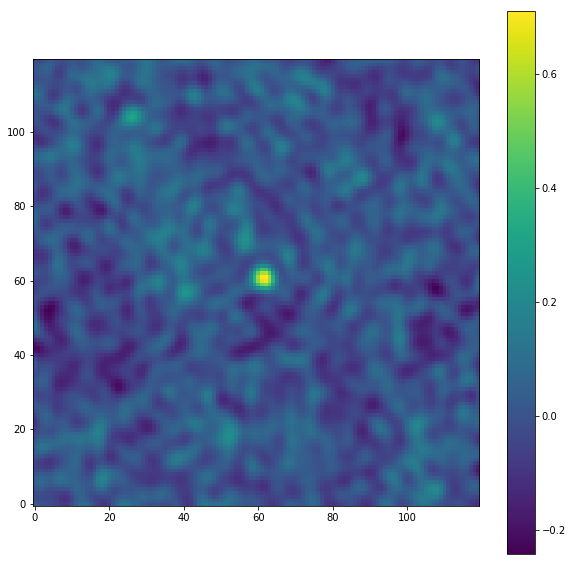

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 180.0  45.0  
CRPIX : 2040.0  2040.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.004166667  0.004166667  
NAXIS : 0  0
[120. 120.] pix
WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'FREQ'  'STOKES'  
CRVAL : 180.0  45.0  73793896.48435  1.0  
CRPIX : 2040.0  2040.0  1.0  1.0  
NAXIS : 4079  4079  1  1


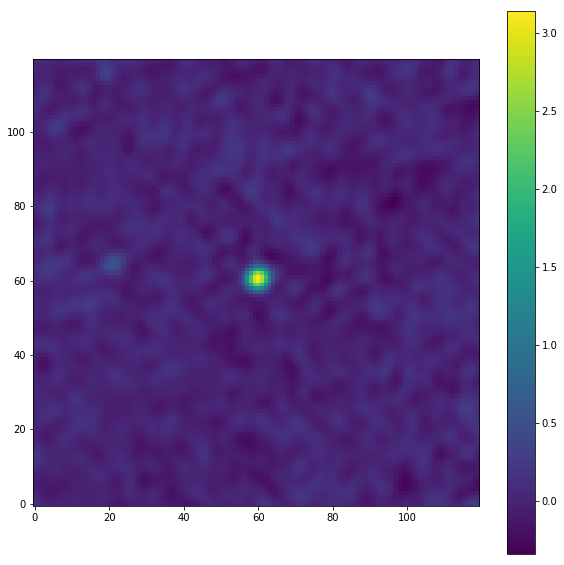

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 180.0  45.0  
CRPIX : 2040.0  2040.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.004166667  0.004166667  
NAXIS : 0  0
[120. 120.] pix
WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'FREQ'  'STOKES'  
CRVAL : 180.0  45.0  73793896.48435  1.0  
CRPIX : 2040.0  2040.0  1.0  1.0  
NAXIS : 4079  4079  1  1


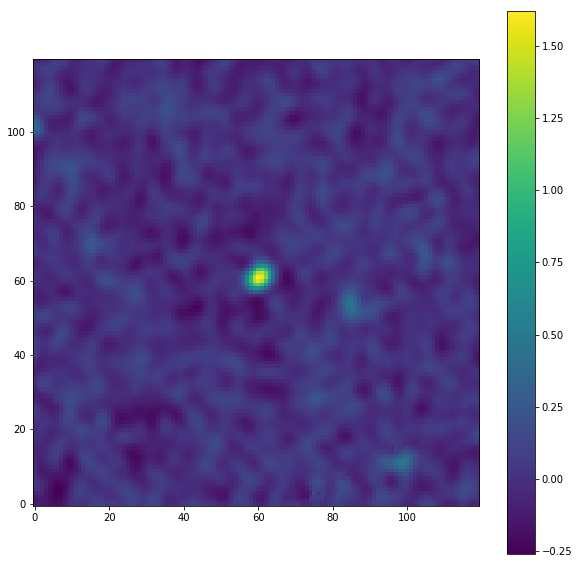

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 180.0  45.0  
CRPIX : 2040.0  2040.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.004166667  0.004166667  
NAXIS : 0  0
[120. 120.] pix
WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'FREQ'  'STOKES'  
CRVAL : 180.0  45.0  73793896.48435  1.0  
CRPIX : 2040.0  2040.0  1.0  1.0  
NAXIS : 4079  4079  1  1


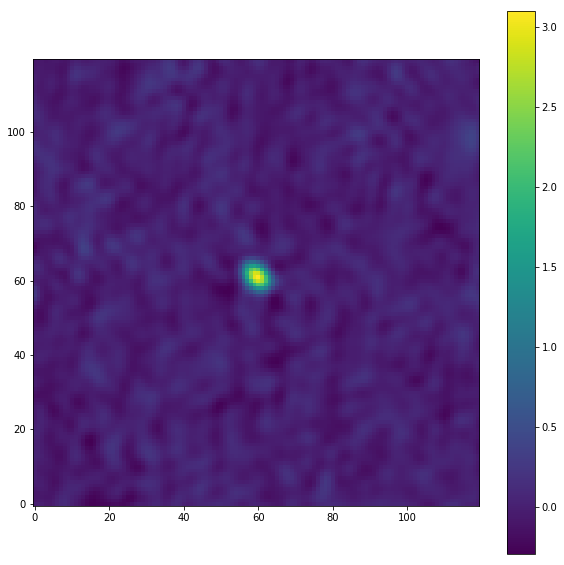

In [44]:
os.chdir(homedir)
os.chdir(newdir)

for i in PosVar.instances:
    if i.dataname == 'vlssr':
        ct.GetCutout('../vlssrimage.fits',i.ra,i.dec,i.id,'vlssr')
#         ct.GetCutout('../vlssrimage.fits',i.ra,i.dec,i.id,(120,120),'vlssr')

# Make cutouts tgss

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 184.9973647014  46.77399545885  
CRPIX : 2643.0  2807.0  
CD1_1 CD1_2  : -0.001722222194076  0.0  
CD2_1 CD2_2  : 0.0  0.001722222194076  
NAXIS : 0  0
[120. 120.] pix
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 184.9973647014  46.77399545885  
CRPIX : 2643.0  2807.0  
CD1_1 CD1_2  : -0.001722222194076  0.0  
CD2_1 CD2_2  : 0.0  0.001722222194076  
NAXIS : 5285  5613


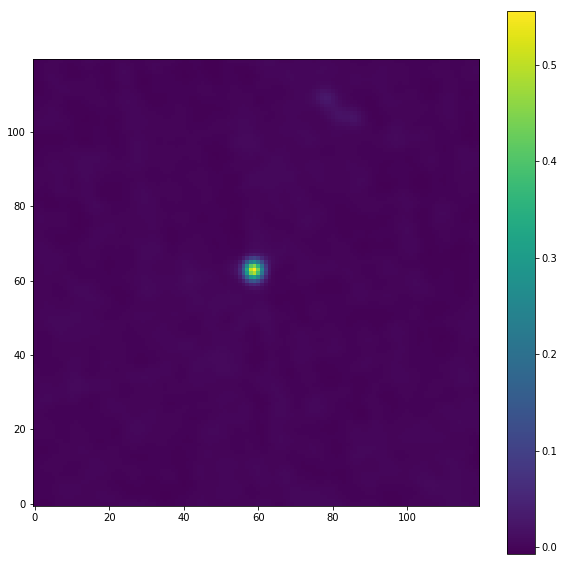

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 184.9973647014  46.77399545885  
CRPIX : 2643.0  2807.0  
CD1_1 CD1_2  : -0.001722222194076  0.0  
CD2_1 CD2_2  : 0.0  0.001722222194076  
NAXIS : 0  0
[120. 120.] pix
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 184.9973647014  46.77399545885  
CRPIX : 2643.0  2807.0  
CD1_1 CD1_2  : -0.001722222194076  0.0  
CD2_1 CD2_2  : 0.0  0.001722222194076  
NAXIS : 5285  5613


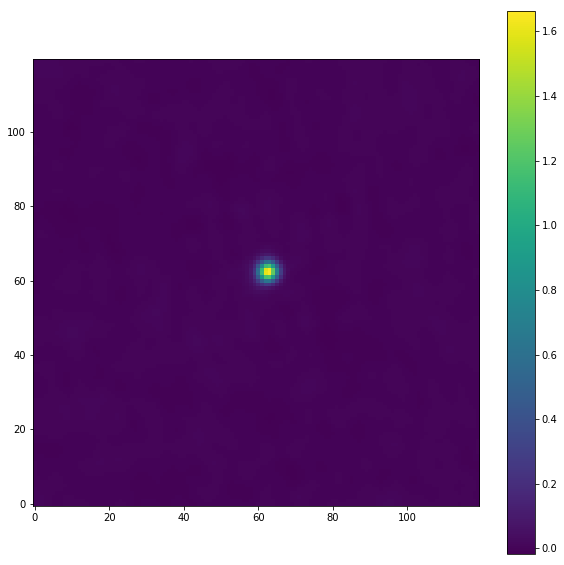

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 184.9973647014  46.77399545885  
CRPIX : 2643.0  2807.0  
CD1_1 CD1_2  : -0.001722222194076  0.0  
CD2_1 CD2_2  : 0.0  0.001722222194076  
NAXIS : 0  0
[120. 120.] pix
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 184.9973647014  46.77399545885  
CRPIX : 2643.0  2807.0  
CD1_1 CD1_2  : -0.001722222194076  0.0  
CD2_1 CD2_2  : 0.0  0.001722222194076  
NAXIS : 5285  5613


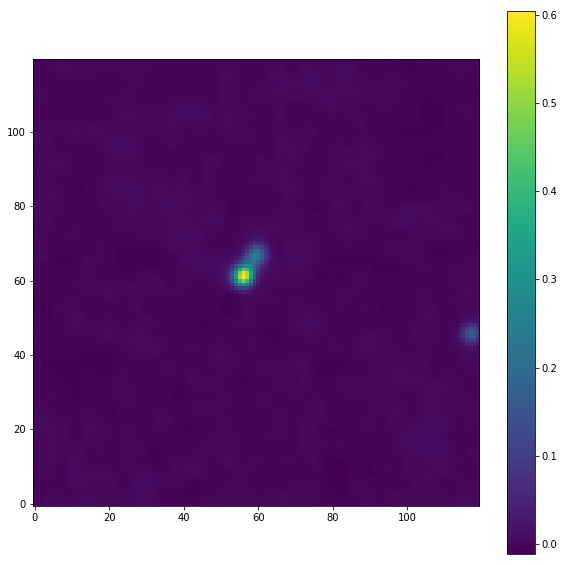

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 184.9973647014  46.77399545885  
CRPIX : 2643.0  2807.0  
CD1_1 CD1_2  : -0.001722222194076  0.0  
CD2_1 CD2_2  : 0.0  0.001722222194076  
NAXIS : 0  0
[120. 120.] pix
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 184.9973647014  46.77399545885  
CRPIX : 2643.0  2807.0  
CD1_1 CD1_2  : -0.001722222194076  0.0  
CD2_1 CD2_2  : 0.0  0.001722222194076  
NAXIS : 5285  5613


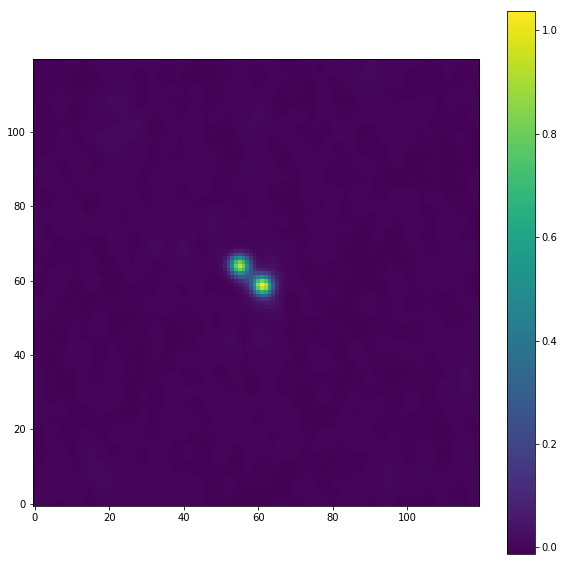

In [45]:
os.chdir(homedir)
# os.rename('tgssimage.fits','/'+newdir+"tgssimage.fits")
os.chdir(newdir)

for i in PosVar.instances:
    if i.dataname == 'tgss':
        ct.GetCutout('../tgssimage.fits',i.ra,i.dec,i.id,'tgss')
#         ct.GetCutout('../tgssimage.fits',i.ra,i.dec,i.id,(120,120),'tgss')


##VLSSR

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 180.0  45.0  
CRPIX : 2040.0  2040.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.004166667  0.004166667  
NAXIS : 0  0
[120. 120.] pix
WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'FREQ'  'STOKES'  
CRVAL : 180.0  45.0  73793896.48435  1.0  
CRPIX : 2040.0  2040.0  1.0  1.0  
NAXIS : 4079  4079  1  1
##TGSS
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 184.9973647014  46.77399545885  
CRPIX : 2643.0  2807.0  
CD1_1 CD1_2  : -0.001722222194076  0.0  
CD2_1 CD2_2  : 0.0  0.001722222194076  
NAXIS : 0  0
[120. 120.] pix
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 184.9973647014  46.77399545885  
CRPIX : 2643.0  2807.0  
CD1_1 CD1_2  : -0.001722222194076  0.0  
CD2_1 CD2_2  : 0.0  0.001722222194076  
NAXIS : 5285  5613



# Check weird source!

3743
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 180.0  45.0  
CRPIX : 2040.0  2040.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.004166667  0.004166667  
NAXIS : 0  0
[120. 120.] pix
WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'FREQ'  'STOKES'  
CRVAL : 180.0  45.0  73793896.48435  1.0  
CRPIX : 2040.0  2040.0  1.0  1.0  
NAXIS : 4079  4079  1  1


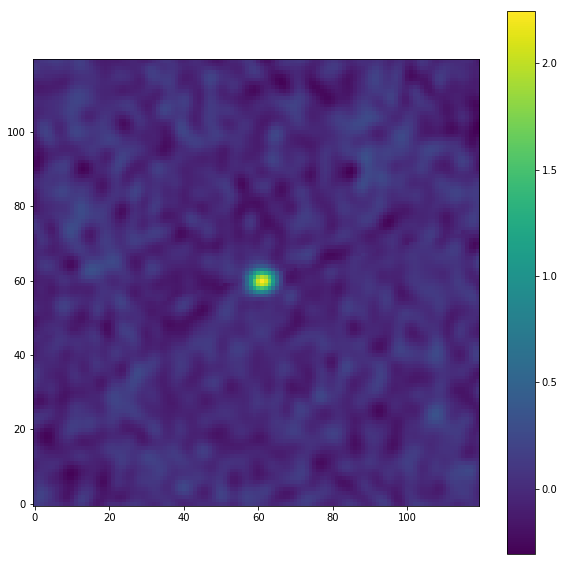

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 184.9973647014  46.77399545885  
CRPIX : 2643.0  2807.0  
CD1_1 CD1_2  : -0.001722222194076  0.0  
CD2_1 CD2_2  : 0.0  0.001722222194076  
NAXIS : 0  0
[120. 120.] pix
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 184.9973647014  46.77399545885  
CRPIX : 2643.0  2807.0  
CD1_1 CD1_2  : -0.001722222194076  0.0  
CD2_1 CD2_2  : 0.0  0.001722222194076  
NAXIS : 5285  5613


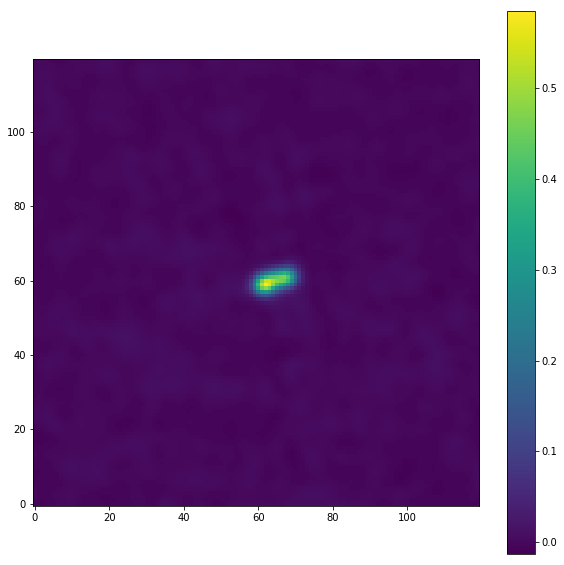

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : -174.71428  47.49272  
CRPIX : 4097.0  4097.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.00111111111111111  0.00111111111111111  
NAXIS : 0  0
[120. 120.] pix
WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'FREQ'  'STOKES'  
CRVAL : -174.71428  47.49272  143650817.871094  1.0  
CRPIX : 4097.0  4097.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.00111111111111111  0.00111111111111111  46875000.0  1.0  
NAXIS : 8192  8192  1  1


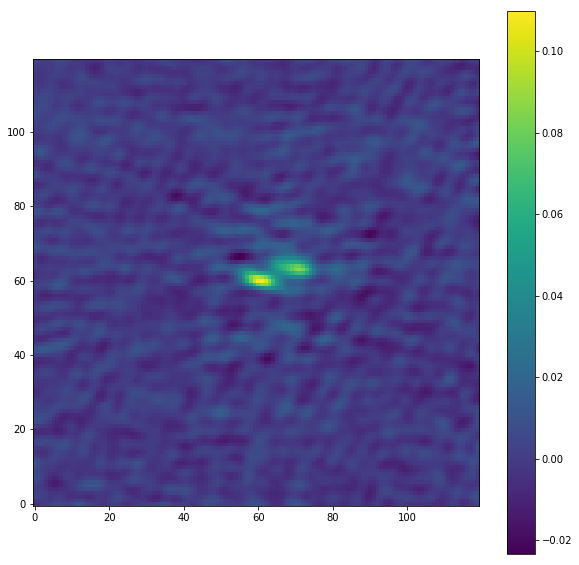

4320
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 180.0  45.0  
CRPIX : 2040.0  2040.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.004166667  0.004166667  
NAXIS : 0  0
[120. 120.] pix
WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'FREQ'  'STOKES'  
CRVAL : 180.0  45.0  73793896.48435  1.0  
CRPIX : 2040.0  2040.0  1.0  1.0  
NAXIS : 4079  4079  1  1


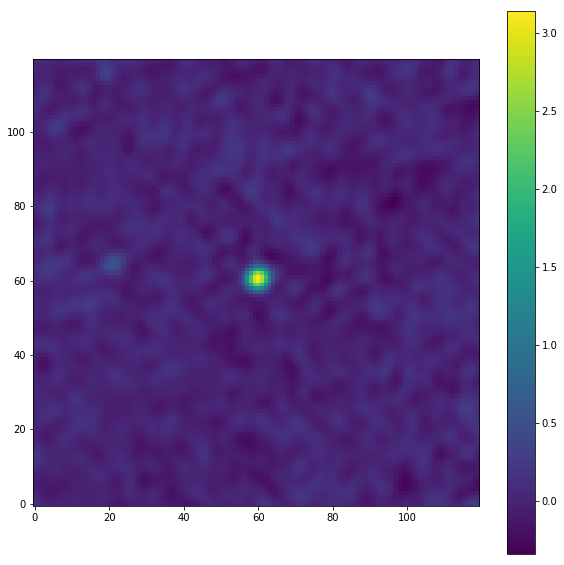

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 184.9973647014  46.77399545885  
CRPIX : 2643.0  2807.0  
CD1_1 CD1_2  : -0.001722222194076  0.0  
CD2_1 CD2_2  : 0.0  0.001722222194076  
NAXIS : 0  0
[120. 120.] pix
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 184.9973647014  46.77399545885  
CRPIX : 2643.0  2807.0  
CD1_1 CD1_2  : -0.001722222194076  0.0  
CD2_1 CD2_2  : 0.0  0.001722222194076  
NAXIS : 5285  5613


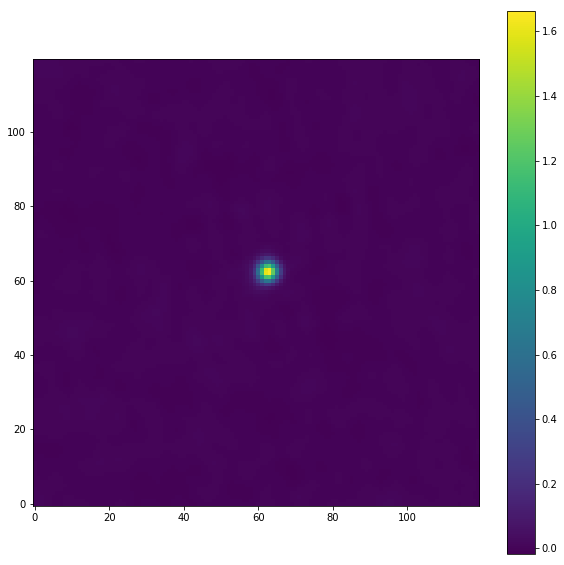

181.149789038
48.9483459916
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : -174.71428  47.49272  
CRPIX : 4097.0  4097.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.00111111111111111  0.00111111111111111  
NAXIS : 0  0
[120. 120.] pix
WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'FREQ'  'STOKES'  
CRVAL : -174.71428  47.49272  143650817.871094  1.0  
CRPIX : 4097.0  4097.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.00111111111111111  0.00111111111111111  46875000.0  1.0  
NAXIS : 8192  8192  1  1


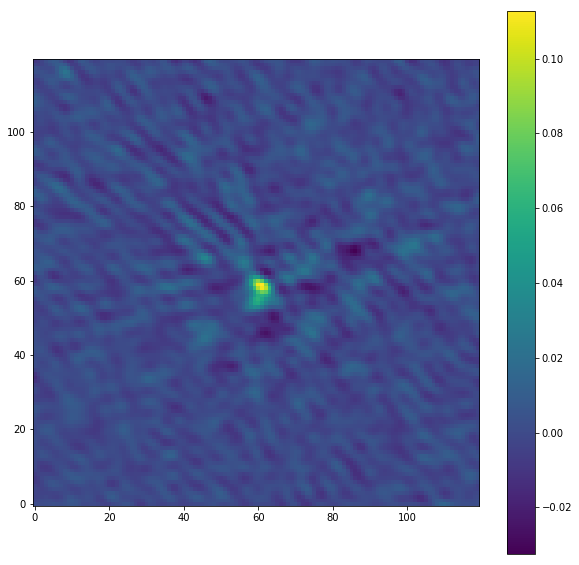

3743
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 180.0  45.0  
CRPIX : 2040.0  2040.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.004166667  0.004166667  
NAXIS : 0  0
[120. 120.] pix
WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'FREQ'  'STOKES'  
CRVAL : 180.0  45.0  73793896.48435  1.0  
CRPIX : 2040.0  2040.0  1.0  1.0  
NAXIS : 4079  4079  1  1


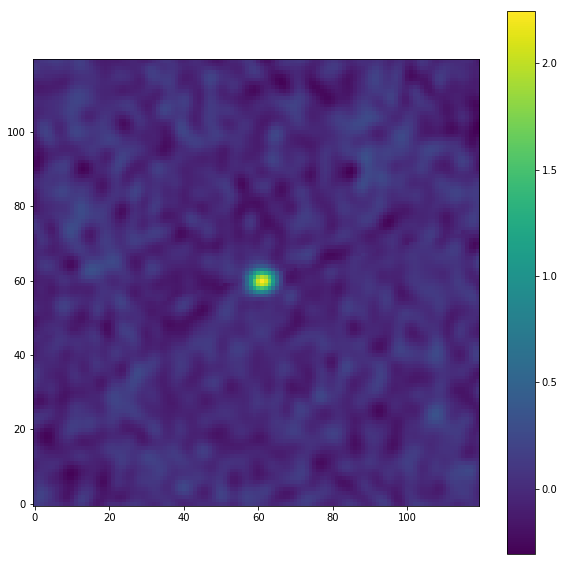

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 184.9973647014  46.77399545885  
CRPIX : 2643.0  2807.0  
CD1_1 CD1_2  : -0.001722222194076  0.0  
CD2_1 CD2_2  : 0.0  0.001722222194076  
NAXIS : 0  0
[120. 120.] pix
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 184.9973647014  46.77399545885  
CRPIX : 2643.0  2807.0  
CD1_1 CD1_2  : -0.001722222194076  0.0  
CD2_1 CD2_2  : 0.0  0.001722222194076  
NAXIS : 5285  5613


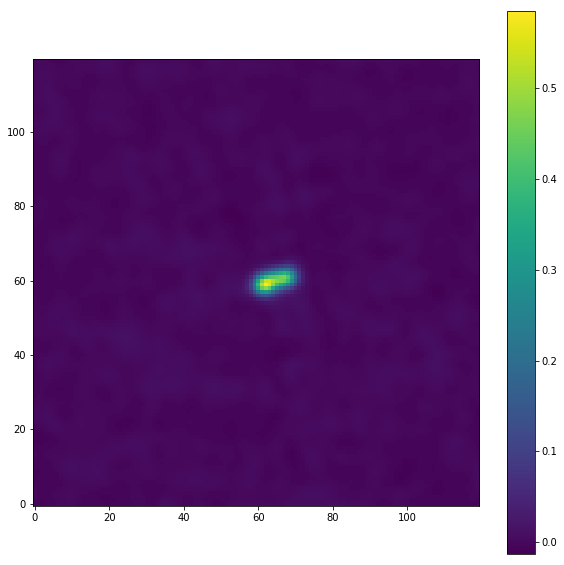

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : -174.71428  47.49272  
CRPIX : 4097.0  4097.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.00111111111111111  0.00111111111111111  
NAXIS : 0  0
[120. 120.] pix
WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'FREQ'  'STOKES'  
CRVAL : -174.71428  47.49272  143650817.871094  1.0  
CRPIX : 4097.0  4097.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.00111111111111111  0.00111111111111111  46875000.0  1.0  
NAXIS : 8192  8192  1  1


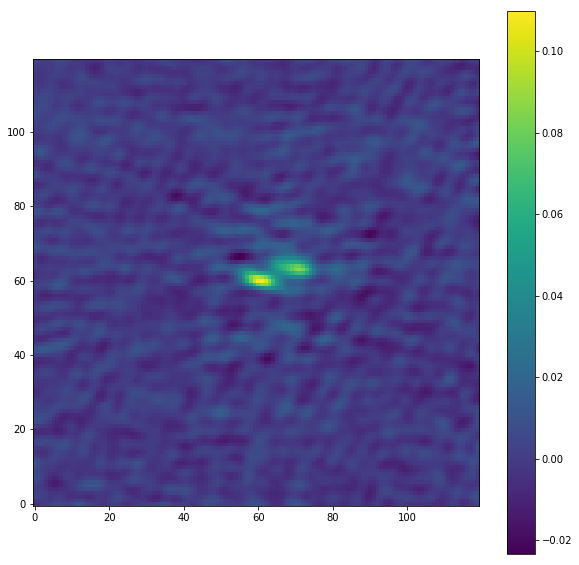

4320
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 180.0  45.0  
CRPIX : 2040.0  2040.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.004166667  0.004166667  
NAXIS : 0  0
[120. 120.] pix
WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'FREQ'  'STOKES'  
CRVAL : 180.0  45.0  73793896.48435  1.0  
CRPIX : 2040.0  2040.0  1.0  1.0  
NAXIS : 4079  4079  1  1


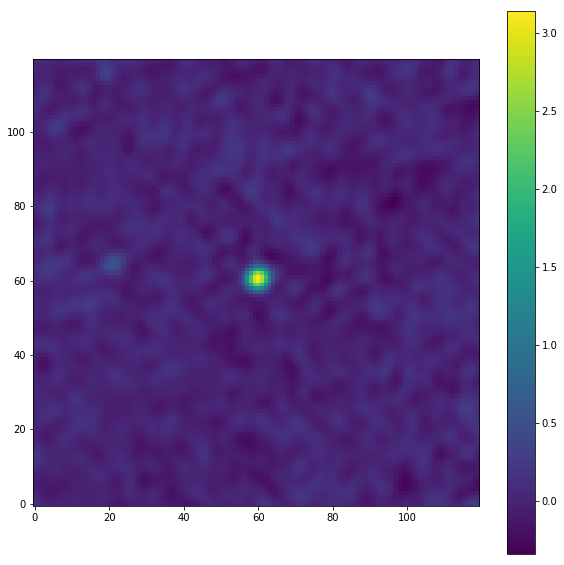

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 184.9973647014  46.77399545885  
CRPIX : 2643.0  2807.0  
CD1_1 CD1_2  : -0.001722222194076  0.0  
CD2_1 CD2_2  : 0.0  0.001722222194076  
NAXIS : 0  0
[120. 120.] pix
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 184.9973647014  46.77399545885  
CRPIX : 2643.0  2807.0  
CD1_1 CD1_2  : -0.001722222194076  0.0  
CD2_1 CD2_2  : 0.0  0.001722222194076  
NAXIS : 5285  5613


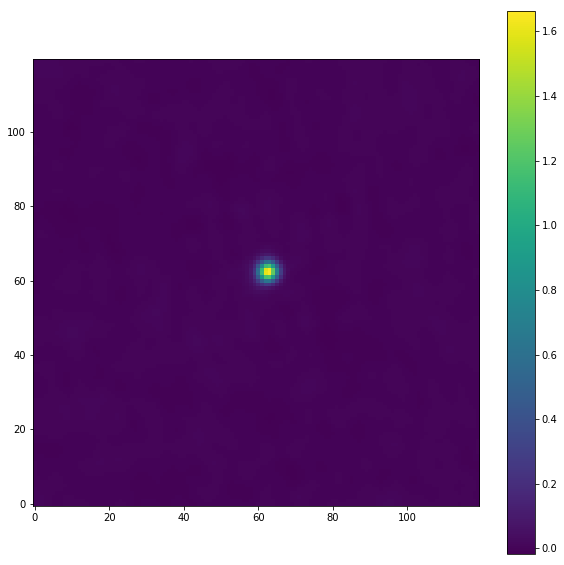

181.149789038
48.9483459916
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : -174.71428  47.49272  
CRPIX : 4097.0  4097.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.00111111111111111  0.00111111111111111  
NAXIS : 0  0
[120. 120.] pix
WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'FREQ'  'STOKES'  
CRVAL : -174.71428  47.49272  143650817.871094  1.0  
CRPIX : 4097.0  4097.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.00111111111111111  0.00111111111111111  46875000.0  1.0  
NAXIS : 8192  8192  1  1


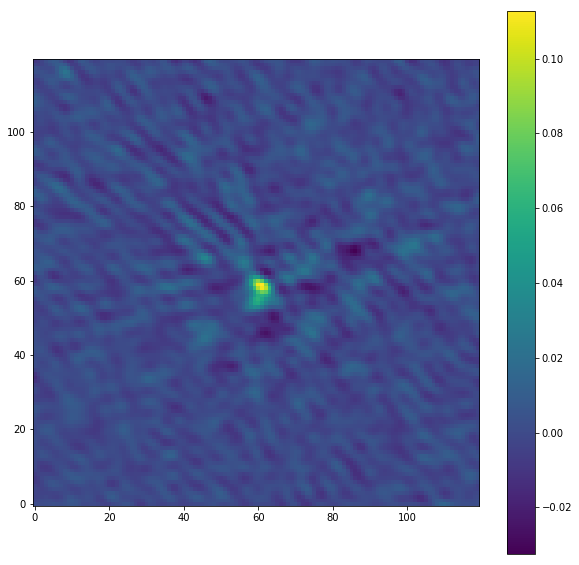

In [46]:
for i in FluxVar.instances:
    if i.id == 3743:
        print i.id
        ct.GetCutout('../vlssrimage.fits',i.ra,i.dec,i.id,'vlssr')
        ct.GetCutout('../tgssimage.fits',i.ra,i.dec,i.id,'tgss')
        url = '/scratch/kmeulen/SourceSubstractedP23HetdexDir/Images/August/10min/10min_allband-t0018-image-pb.fits'
        ct.GetCutout(url,i.ra,i.dec,i.id)
    if i.id == 4320:
        print i.id
        ct.GetCutout('../vlssrimage.fits',i.ra,i.dec,i.id,'vlssr')
        ct.GetCutout('../tgssimage.fits',i.ra,i.dec,i.id,'tgss')
        print i.ra
        print i.dec
        url = '/scratch/kmeulen/SourceSubstractedP23HetdexDir/Images/August/10min/10min_allband-t0029-image-pb.fits'
#         print i.ra
#         print i.dec
#         url = '/scratch/kmeulen/SourceSubstractedP23HetdexDir/Images/August/1hr/1hr_allband-t0003-image-pb.fits'
        
        ct.GetCutout(i.url[0],i.ra,i.dec,i.id)

# Make cutouts of own dataset

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : -174.71428  47.49272  
CRPIX : 4097.0  4097.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.00111111111111111  0.00111111111111111  
NAXIS : 0  0
[120. 120.] pix
WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'FREQ'  'STOKES'  
CRVAL : -174.71428  47.49272  143650817.871094  1.0  
CRPIX : 4097.0  4097.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.00111111111111111  0.00111111111111111  46875000.0  1.0  
NAXIS : 8192  8192  1  1


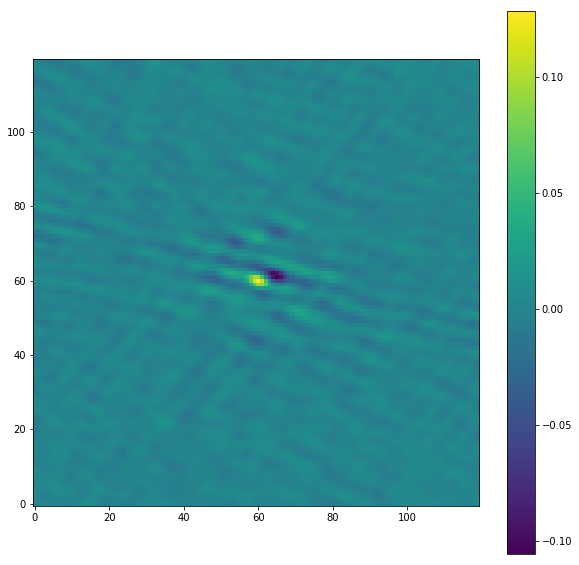

[u'/scratch/kmeulen/SourceSubstractedP23HetdexDir/Images/August/10min/10min_allband-t0041-image-pb.fits']
4942
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : -174.71428  47.49272  
CRPIX : 4097.0  4097.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.00111111111111111  0.00111111111111111  
NAXIS : 0  0
[120. 120.] pix
WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'FREQ'  'STOKES'  
CRVAL : -174.71428  47.49272  143650817.871094  1.0  
CRPIX : 4097.0  4097.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.00111111111111111  0.00111111111111111  46875000.0  1.0  
NAXIS : 8192  8192  1  1


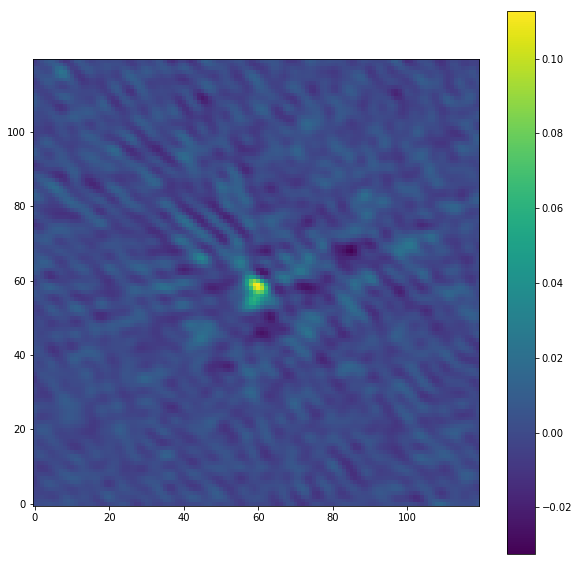

[u'/scratch/kmeulen/SourceSubstractedP23HetdexDir/Images/August/10min/10min_allband-t0041-image-pb.fits']
5064
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : -174.71428  47.49272  
CRPIX : 4097.0  4097.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.00111111111111111  0.00111111111111111  
NAXIS : 0  0
[120. 120.] pix
WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'FREQ'  'STOKES'  
CRVAL : -174.71428  47.49272  143650817.871094  1.0  
CRPIX : 4097.0  4097.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.00111111111111111  0.00111111111111111  46875000.0  1.0  
NAXIS : 8192  8192  1  1


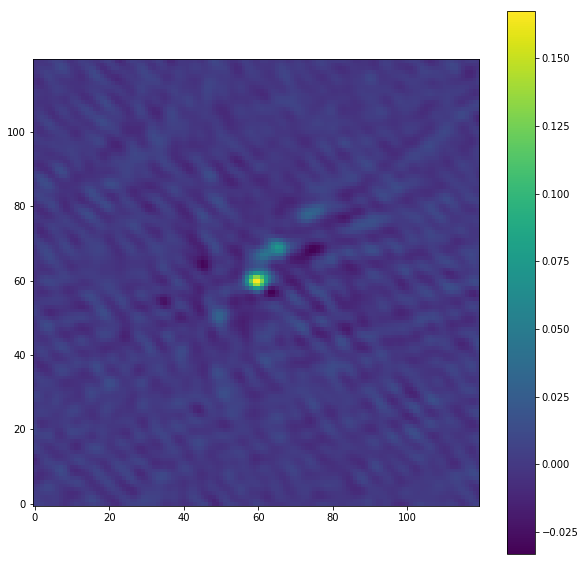

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : -174.71428  47.49272  
CRPIX : 4097.0  4097.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.00111111111111111  0.00111111111111111  
NAXIS : 0  0
[120. 120.] pix
WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'FREQ'  'STOKES'  
CRVAL : -174.71428  47.49272  143650817.871094  1.0  
CRPIX : 4097.0  4097.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.00111111111111111  0.00111111111111111  46875000.0  1.0  
NAXIS : 8192  8192  1  1


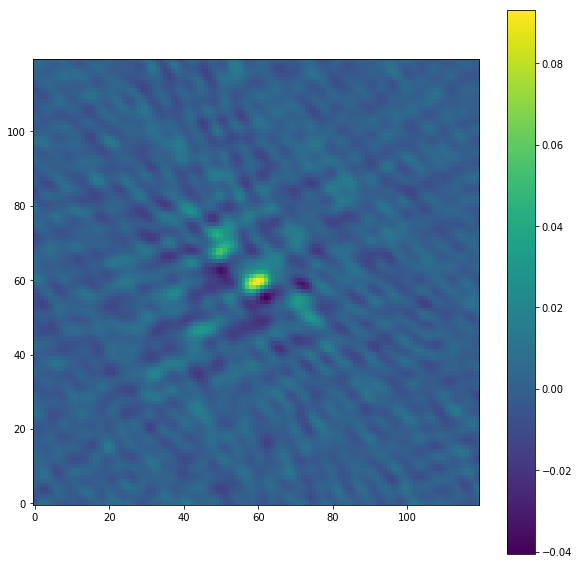

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : -174.71428  47.49272  
CRPIX : 4097.0  4097.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.00111111111111111  0.00111111111111111  
NAXIS : 0  0
[120. 120.] pix
WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'FREQ'  'STOKES'  
CRVAL : -174.71428  47.49272  143650817.871094  1.0  
CRPIX : 4097.0  4097.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.00111111111111111  0.00111111111111111  46875000.0  1.0  
NAXIS : 8192  8192  1  1


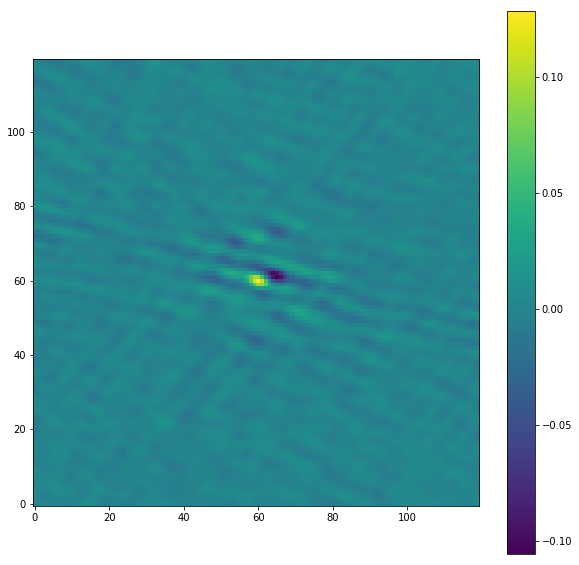

[u'/scratch/kmeulen/SourceSubstractedP23HetdexDir/Images/August/10min/10min_allband-t0041-image-pb.fits']
4942
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : -174.71428  47.49272  
CRPIX : 4097.0  4097.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.00111111111111111  0.00111111111111111  
NAXIS : 0  0
[120. 120.] pix
WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'FREQ'  'STOKES'  
CRVAL : -174.71428  47.49272  143650817.871094  1.0  
CRPIX : 4097.0  4097.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.00111111111111111  0.00111111111111111  46875000.0  1.0  
NAXIS : 8192  8192  1  1


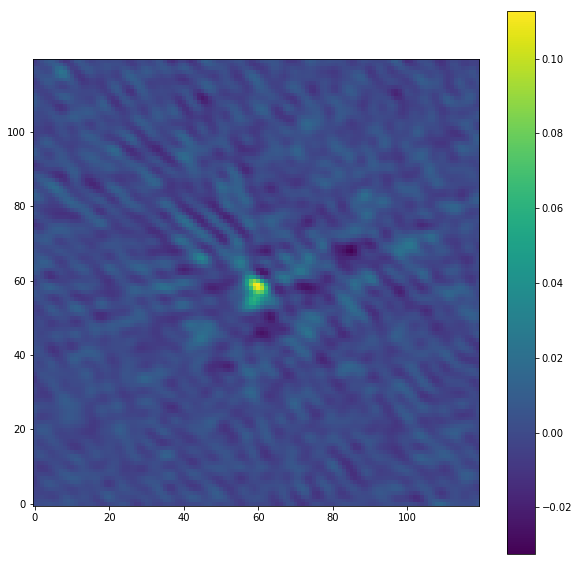

[u'/scratch/kmeulen/SourceSubstractedP23HetdexDir/Images/August/10min/10min_allband-t0041-image-pb.fits']
5064
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : -174.71428  47.49272  
CRPIX : 4097.0  4097.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.00111111111111111  0.00111111111111111  
NAXIS : 0  0
[120. 120.] pix
WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'FREQ'  'STOKES'  
CRVAL : -174.71428  47.49272  143650817.871094  1.0  
CRPIX : 4097.0  4097.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.00111111111111111  0.00111111111111111  46875000.0  1.0  
NAXIS : 8192  8192  1  1


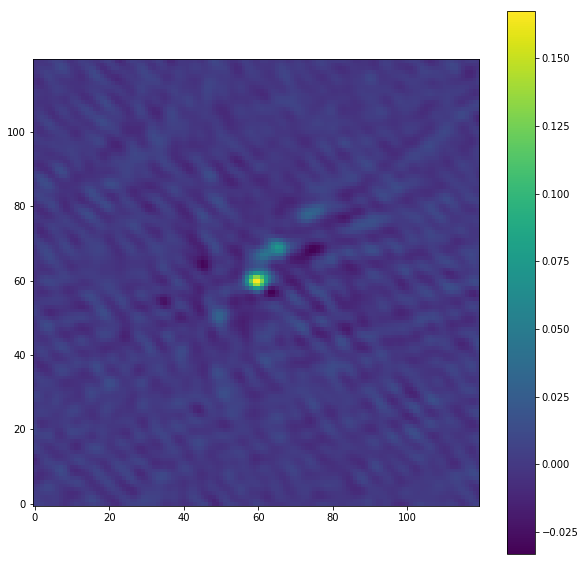

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : -174.71428  47.49272  
CRPIX : 4097.0  4097.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.00111111111111111  0.00111111111111111  
NAXIS : 0  0
[120. 120.] pix
WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'FREQ'  'STOKES'  
CRVAL : -174.71428  47.49272  143650817.871094  1.0  
CRPIX : 4097.0  4097.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.00111111111111111  0.00111111111111111  46875000.0  1.0  
NAXIS : 8192  8192  1  1


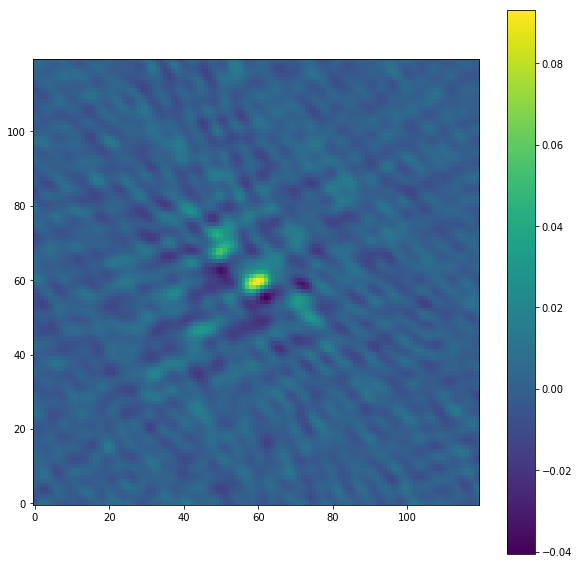

In [47]:
os.chdir(homedir)
os.chdir(newdir)
for i in PosVar.instances:
        if i.id == 4977:
            url = '/scratch/kmeulen/SourceSubstractedP23HetdexDir/Images/August/10min/10min_allband-t0040-image-pb.fits'
            ct.GetCutout(url,i.ra,i.dec,i.id)
        elif i.id == 4209:
            url = '/scratch/kmeulen/SourceSubstractedP23HetdexDir/Images/August/10min/10min_allband-t0025-image-pb.fits'
            
            ct.GetCutout(url,i.ra,i.dec,i.id)
        
        else:
            print i.url
            print i.id
            ct.GetCutout(i.url[0],i.ra,i.dec,i.id)

# 1min_allband_2048_8asec-t0193-image-pb.fits

# plot in Latex

In [48]:
# print "\\begin{longtable}{m{1cm}|m{6cm}|m{6cm}|m{6cm}} \n\
# \\toprule \nId & Data & TGSS (deg)& VLSSR  \\\\\\midrule \n\\endfirsthead \n\\toprule \
# \nId & Data & TGSS (deg)& VLSSR   \\\\\\midrule \n\\endhead \n\\bottomrule \n\\endfoot \n\\bottomrule"

# # define caption for table
# print "\\caption{ Comparison position of candidates with different databases for the 1hr interval data} \n\\endlastfoot"

# for i in samesieslist:
#     a = "\\raisebox{-\\totalheight}{\\includegraphics[width=6cm, height=6cm]{"+technique+"/"+str(i[0])+"cutout_own.png}}"+" & "
#     if i[1] == "tgss":
#         b = ("\\raisebox{-\\totalheight}{\\includegraphics[width=6cm, height=6cm]{"+technique+"/"+str(i[0])+"cutout_tgss.png}}"+" & - \\\\")
#     if i[1] =="vlssr":
#         b = ("- & \\raisebox{-\\totalheight}{\\includegraphics[width=6cm, height=6cm]{"+technique+"/"+str(i[0])+"cutout_vlssr.png}} \\\\")
#     if i[1] == "tgss \\& vlssr":
#         b = ("\\raisebox{-\\totalheight}{\\includegraphics[width=6cm, height=6cm]{"+technique+"/"+str(i[0])+"cutout_tgss.png}}"+" "+ "&"\
#                 + " "+ "\\raisebox{-\\totalheight}{\\includegraphics[width=6cm, height=6cm]{"+technique+"/"+str(i[0])+"cutout_vlssr.png}} \\\\")
#     print latexHREF +str(i[0])+"}" + "{%i}" %i[0]+" "+ "&"+ " "+ a + b

# print "\\end{longtable}"


#  PRINT EVERYTHING IN LATEX IN ONE GO

In [49]:
folder = technique+"_"+timescale+"/"
##############################
# HERE WE PRINT THE NECESSARY PACKAGES
##############################
print"""
\documentclass{article}
\usepackage[utf8]{inputenc}
\usepackage[utf8]{inputenc}
\usepackage{geometry}
\usepackage{booktabs}
\usepackage{array}
\usepackage{graphicx}% delete the demo option in your actual code
\usepackage{longtable}
\usepackage{pdflscape}
\usepackage{mathabx}
\usepackage{float}
\usepackage{multirow}
\usepackage{multicol}
\usepackage{bigstrut}
\usepackage{caption}
\usepackage{subcaption}
\usepackage{siunitx}
\usepackage{makecell}
\usepackage{textcomp}
\usepackage{titlesec}
\usepackage[para]{footmisc}
\usepackage[nottoc]{tocbibind}
\usepackage{hyperref}
\geometry{lmargin=.5cm,bmargin=0.5cm,rmargin=1.5cm}
\hypersetup{
    colorlinks=true,
    linkcolor=blue,
    filecolor=magenta,      
    urlcolor=cyan,
}
\\begin{document}
"""
##########################
# HERE WE PRINT THE NUMBER TABLES OF POSITION VARIATING SOURCES
###########################
print "\\section{Position variating Sources}\\label{possection:"+technique+":"+timescale+"}\n"
samesieslist = []
for i in range(len(PosVar.instances)):
    samesie = False
    
#   create combined name if entry both in vlssr and tgss
    for j in range(len(samesieslist)):
        if PosVar.instances[i].id == samesieslist[j][0]:
            samesieslist[j][1] = samesieslist[j][1] + " \& " + PosVar.instances[i].database.name
            samesie = True
    if not samesie:
        samesieslist.append([PosVar.instances[i].id,PosVar.instances[i].database.name,PosVar.instances[i]])
    
samesieslist = sorted(samesieslist, key=itemgetter(1))

print "\\begin{longtable}{c|c|c|c|c} \n\
\\toprule \nDatabase & Ra (deg) & Dec (deg)& Fk5 & Id/Link \\\\\\midrule \n\\endfirsthead \n\\toprule \
\nDatabase & Ra (deg) & Dec (deg) & Fk5 &Id/Link  \\\\\\midrule \n\\endhead \n\\bottomrule \n\\endfoot \n\\bottomrule"

# define caption for table
print "\\caption{ Comparison position of candidates with TGSS and VLSSR for the " +timescale+" timescale data} \n\\endlastfoot\n\
\\label{"+technique+":"+timescale+":tablepos"+"}\n"

lastname = None
for i in samesieslist:
    if i[1] != lastname and lastname:
        print "\\hline"
    print i[1] +" "+ "&"+ " "+ '%0.3f' %i[2].ra + " " + "&"+ " "+ "%0.3f" %(i[2].dec) +\
    " " + "&" + " " +i[2].fk5 +" " + '&' + "  "+ latexHREF +str(i[0])+"}" + "{%i}" %i[0] +" \\" + "\\"
    
    lastname = i[1]

print "\\end{longtable}\n"


#########################
# HERE WE PRINT HE FIGURE TABLES
#####################
print "\\subsection{Images}"

print "\\begin{longtable}{m{1cm}|m{6cm}|m{6cm}|m{6cm}} \n\
\\toprule \nId & Data & TGSS (deg)& VLSSR  \\\\\\midrule \n\\endfirsthead \n\\toprule \
\nId & Data & TGSS (deg)& VLSSR   \\\\\\midrule \n\\endhead \n\\bottomrule \n\\endfoot \n\\bottomrule"

# define caption for table
print "\\caption{Images to compare the  position of our candidates with TGSS and VLSSR for the " +timescale+" timescale data} \n\\endlastfoot"
print "\\label{"+technique+":"+timescale+":tablepos_images"+"}"
for i in samesieslist:
    a = "\\raisebox{-\\totalheight}{\\includegraphics[width=6cm, height=6cm]{"+folder+str(i[0])+"cutout_own.png}}"+" & "
    if i[1] == "tgss":
        b = ("\\raisebox{-\\totalheight}{\\includegraphics[width=6cm, height=6cm]{"+folder+str(i[0])+"cutout_tgss.png}}"+" & - \\\\")
    if i[1] =="vlssr":
        b = ("- & \\raisebox{-\\totalheight}{\\includegraphics[width=6cm, height=6cm]{"+folder+str(i[0])+"cutout_vlssr.png}} \\\\")
    if i[1] == "tgss \\& vlssr":
        b = ("\\raisebox{-\\totalheight}{\\includegraphics[width=6cm, height=6cm]{"+folder+str(i[0])+"cutout_tgss.png}}"+" "+ "&"\
                + " "+ "\\raisebox{-\\totalheight}{\\includegraphics[width=6cm, height=6cm]{"+folder+str(i[0])+"cutout_vlssr.png}} \\\\")
    print latexHREF +str(i[0])+"}" + "{%i}" %i[0]+" "+ "&"+ " "+ a + b

print "\\end{longtable}\n"

##########################
# HERE WE PRINT THE NUMBER TABLES OF FLUX VARIATING SOURCES
###########################

print "\\begin{landscape}\n"
print "\\section{Fluxvariating Sources}\\label{varsection:"+technique+":"+timescale+"}\n"
# SEPERATE DATABASES
databaselist = ['tgss','vlssr']

samesieslist = []
for i in range(len(FluxVar.instances)):
    samesie = False
    tempdict = {'tgss':None,'vlssr':None,'id':None,'ra':None,'dec':None,'fk5':None}
    
#   create combined name if entry both in vlssr and tgss
    for j in range(len(samesieslist)):
        if FluxVar.instances[i].id == samesieslist[j]['id']:
#             samesieslist[j].append(FluxVar.instances[i])
            samesieslist[j][FluxVar.instances[i].database.name] = FluxVar.instances[i]
          
            samesie = True
    if not samesie:
        tempdict[FluxVar.instances[i].database.name] = FluxVar.instances[i]
        tempdict['id'] = FluxVar.instances[i].id
        tempdict['ra'] = FluxVar.instances[i].ra
        tempdict['dec'] = FluxVar.instances[i].dec
        tempdict['fk5'] = FluxVar.instances[i].fk5
        samesieslist.append(tempdict)


print "\\begin{longtable}{c|c|c|c|c|c|c|c|c|c|c|c} \n\
\\toprule \nFlux147.5MHz (Jy) & Tgss (Jy) & Flux74MHz (Jy)& Vlssr (Jy) & fk5 & Ra (deg) & Dec (deg) &tggsRa&tgssDec&\
vlssrRa&vlssrDec& Id/Link \\\\\\midrule \n\\endfirsthead \n\\toprule \
\nFlux147.5MHz (Jy) & Tgss (Jy) & Flux74MHz (Jy)& Vlssr (Jy)& fk5 & Ra (deg) & Dec (deg)  &tggsRa&tgssDec&\
vlssrRa&vlssrDec& Id/Link \\\\\\midrule \n\\endhead \n\\bottomrule \n\\endfoot \n\\bottomrule"

# define caption for table
print "\\caption{ Comparison of fluxes that vary from catalogues TGSS and VLSSR for " + timescale+" images"+"} \n\\endlastfoot"
print "\\label{"+technique+":"+timescale+":tablevar"+"}"
lastname = None
# samesieslist = sorted(samesieslist, key=lambda e: (e['ra'], e['dec']))
for i in samesieslist:
    a= ''
    b=''
    for j in(databaselist):
        try: 
            a+= str(np.around(i[j].pflux*i[j].scale,3)) + " " + "&"+ " "
        except:
            a += "-" +" "+ "&"+ " "
        try:
            a+= str(np.around(i[j].database.pflux[i[j].entry],3)) + " " + "&"+ " "   
        except:
            a += "-" +" "+ "&"+ " "
            
        try: 
            b+= '%0.3f' %(i[j].database.ra[i[j].entry])+" "+"&"+" "
            b+= '%0.3f' %(i[j].database.dec[i[j].entry])+" "+"&"+" "
        except:
            b+= "-" + " " + "&"+" " "-" + " " + "&"+" "
        
    a +=i['fk5'] + " " + '&' + "  "+ '%0.3f' %i['ra'] + " " + "&"+ " "+ "%0.3f" %i['dec'] \
    + " " + '&' + "  "+ b+ latexHREF +str(i["id"])+"}" + "{%i}" %i['id'] +"  \\" + "\\"
    print a

print "\\end{longtable}\n"
print "\\end{landscape}\n"

################
## HERE ARE THE PLOTS:
################
print "\\subsection{Fits}"

i = 0
try:
    while i < len(storedfitvalueslist):
        print "\
\\begin{figure}[H]\n\
    \\centering\n\
    \\begin{minipage}{.5\\textwidth}\n\
        \\centering\n\
        \\includegraphics[scale = 0.35]{"+folder+timescale+str(storedfitvalueslist[i][0])+".png}\n\
        \\captionsetup{labelformat=empty}\n\
        \\caption{Plot of source: "+latexHREF +str(storedfitvalueslist[i][0])+"}"+"{%i}" %storedfitvalueslist[i][0]\
    +",\\\\with a goodness of fit of: %0.2f and a dof of: %i"\
    %(storedfitvalueslist[i][1],storedfitvalueslist[i][2]) +"}\n\
        \\addtocounter{figure}{-1}\n\
        \\label{"+technique+":"+timescale+":"+str(storedfitvalueslist[i][0]) +":plot}\n\
    \\end{minipage}%\n\
    \\begin{minipage}{0.5\\textwidth}\n\
        \\centering\n"
        try:
            print"\
        \\includegraphics[scale = 0.35]{"+folder+timescale+str(storedfitvalueslist[i+1][0])+".png}\n\
        \\captionsetup{labelformat=empty}\n\
        \\caption{Plot of source: "+latexHREF +str(storedfitvalueslist[i+1][0])+"}"+"{%i}" %storedfitvalueslist[i+1][0]\
    +",\\\\with a goodness of fit of: "+str(storedfitvalueslist[i+1][1].round(2))+\
    " and a dof of: "+str(storedfitvalueslist[i+1][2])+""\
    +"}\n\
    \\addtocounter{figure}{-1}\n\
    \\label{"+technique+":"+timescale+":"+str(storedfitvalueslist[i+1][0]) +":plot}\n\
    \\end{minipage}\n\
\\end{figure}"
        except:
            print "--\n\
        \\end{minipage}\n\
\\end{figure}"
        if (i+2)%8==0 and i !=0:
            if i+2 ==8:
                pass
            else:
                print "\\newpage"
        i+=2
except:
    pass
########    
#JUST FOR ME:
#######
print "\\section{Effect on Candidate List}"
print "\
\\begin{table}[H]\n\
    \\centering\n\
    \\begin{tabular}{|c| c | c|}\n\
    \\toprule\n\
     Step & Candidate list before & Candidate list after\\\\\n\
    \\midrule\n\
        Initial Selector & "+str(initiallenghtcandi)+" & " + str(initialselector) +" \\\\\n\
        PosVarCandi & "+str(initialselector)+" & " + str(posvarcatasave) +" \\\\\n\
        FluxVarCandi & "+str(initialselector)+" & " + str(fluxvarcatasave) +"  \\\\\n\
        \\midrule\n\
    \\end{tabular}\n\
    \\caption{Effect of our script on the size of the candidate list for the "+timescale+" timescale images}\n\
    \\label{"+technique+":"+timescale+":"+"overviewcandidates}\n\
\\end{table}\n"

###############    
# ENDING THE DOCUMENT
##############
print "\\end{document}"


\documentclass{article}
\usepackage[utf8]{inputenc}
\usepackage[utf8]{inputenc}
\usepackage{geometry}
\usepackage{booktabs}
\usepackage{array}
\usepackage{graphicx}% delete the demo option in your actual code
\usepackage{longtable}
\usepackage{pdflscape}
\usepackage{mathabx}
\usepackage{float}
\usepackage{multirow}
\usepackage{multicol}
\usepackage{bigstrut}
\usepackage{caption}
\usepackage{subcaption}
\usepackage{siunitx}
\usepackage{makecell}
\usepackage{textcomp}
\usepackage{titlesec}
\usepackage[para]{footmisc}
\usepackage[nottoc]{tocbibind}
\usepackage{hyperref}
\geometry{lmargin=.5cm,bmargin=0.5cm,rmargin=1.5cm}
\hypersetup{
    colorlinks=true,
    linkcolor=blue,
    filecolor=magenta,      
    urlcolor=cyan,
}
\begin{document}

\section{Position variating Sources}\label{possection:KmeulenSourceSub:10min}

\begin{longtable}{c|c|c|c|c} 
\toprule 
Database & Ra (deg) & Dec (deg)& Fk5 & Id/Link \\\midrule 
\endfirsthead 
\toprule 
Database & Ra (deg) & Dec (deg) & Fk5 &Id/Link  

Go to <a href=#bookmark>beginning</a>
Left off here <a name='bookmark2' />

# Plotting the fits

In [50]:


# i = 0
# while i < len(storedfitvalueslist):
#     print "\
# \\begin{figure}[H]\n\
#     \\centering\n\
#     \\begin{minipage}{.5\\textwidth}\n\
#         \\centering\n\
#         \\includegraphics[scale = 0.35]{"+technique+"/"+timescale+str(storedfitvalueslist[i][0])+".png}\n\
#         \\captionsetup{labelformat=empty}\n\
#         \\caption{\\textbf{a:} Plot of "+latexHREF +str(storedfitvalueslist[i][0])+"}"+"{%i}" %storedfitvalueslist[i][0]\
#     +",\\\\with a goodness of fit of: %0.2f and a dof of: %i"\
#     %(storedfitvalueslist[i][1],storedfitvalueslist[i][2]) +"}\n\
#         \\addtocounter{figure}{-1}\n\
#         \\label{"+technique+":"+timescale+":"+str(storedfitvalueslist[i][0]) +":plot}\n\
#     \\end{minipage}%\n\
#     \\begin{minipage}{0.5\\textwidth}\n\
#         \\centering\n\
#         \\includegraphics[scale = 0.35]{"+technique+"/"+timescale+str(storedfitvalueslist[i][0])+".png}\n\
#         \\captionsetup{labelformat=empty}\n\
#         \\caption{\\textbf{b:} Plot of "+latexHREF +str(storedfitvalueslist[i+1][0])+"}"+"{%i}" %storedfitvalueslist[i+1][0]\
#     +",\\\\with a goodness of fit of: "+str(storedfitvalueslist[i+1][1].round(2))+\
#     " and a dof of: "+str(storedfitvalueslist[i+1][2])+""\
#     +"}\n\
#     \\addtocounter{figure}{-1}\n\
#     \\label{"+technique+":"+timescale+":"+str(storedfitvalueslist[i+1][0]) +":plot}\n\
#     \\end{minipage}\n\
# \\end{figure}"
#     if (i+2)%8==0 and i !=0:
#         if i+2 ==8:
#             pass
#         else:
#             print "\\newpage"
#     i+=2

# In case no sources

In [51]:
print"""
\documentclass{article}
\usepackage[utf8]{inputenc}
\usepackage[utf8]{inputenc}
\usepackage{geometry}
\usepackage{booktabs}
\usepackage{array}
\usepackage{graphicx}% delete the demo option in your actual code
\usepackage{longtable}
\usepackage{pdflscape}
\usepackage{mathabx}
\usepackage{float}
\usepackage{multirow}
\usepackage{multicol}
\usepackage{bigstrut}
\usepackage{caption}
\usepackage{subcaption}
\usepackage{siunitx}
\usepackage{makecell}
\usepackage{textcomp}
\usepackage{titlesec}
\usepackage[para]{footmisc}
\usepackage[nottoc]{tocbibind}
\usepackage{hyperref}
\geometry{lmargin=.5cm,bmargin=0.5cm,rmargin=1.5cm}
\hypersetup{
    colorlinks=true,
    linkcolor=blue,
    filecolor=magenta,      
    urlcolor=cyan,
}
\\begin{document}
"""


print "\\section{Effect on Candidate List}"
print "\
\\begin{table}[H]\n\
    \\centering\n\
    \\begin{tabular}{|c| c | c|}\n\
    \\toprule\n\
     Step & Candidate list before & Candidate list after\\\\\n\
    \\midrule\n\
        Initial Selector & "+str(0)+" & " + str(0) +" \\\\\n\
        PosVarCandi & "+str(0)+" & " + str(0) +" \\\\\n\
        FluxVarCandi & "+str(0)+" & " + str(0) +"  \\\\\n\
        \\midrule\n\
    \\end{tabular}\n\
    \\caption{Effect of our script on the size of the candidate list for the "+timescale+" timescale images}\n\
    \\label{"+technique+":"+timescale+":"+"overviewcandidates}\n\
\\end{table}\n"


print "\\end{document}"


\documentclass{article}
\usepackage[utf8]{inputenc}
\usepackage[utf8]{inputenc}
\usepackage{geometry}
\usepackage{booktabs}
\usepackage{array}
\usepackage{graphicx}% delete the demo option in your actual code
\usepackage{longtable}
\usepackage{pdflscape}
\usepackage{mathabx}
\usepackage{float}
\usepackage{multirow}
\usepackage{multicol}
\usepackage{bigstrut}
\usepackage{caption}
\usepackage{subcaption}
\usepackage{siunitx}
\usepackage{makecell}
\usepackage{textcomp}
\usepackage{titlesec}
\usepackage[para]{footmisc}
\usepackage[nottoc]{tocbibind}
\usepackage{hyperref}
\geometry{lmargin=.5cm,bmargin=0.5cm,rmargin=1.5cm}
\hypersetup{
    colorlinks=true,
    linkcolor=blue,
    filecolor=magenta,      
    urlcolor=cyan,
}
\begin{document}

\section{Effect on Candidate List}
\begin{table}[H]
    \centering
    \begin{tabular}{|c| c | c|}
    \toprule
     Step & Candidate list before & Candidate list after\\
    \midrule
        Initial Selector & 0 & 0 \\
        PosVarCandi & 0 & 0 \\
